In [1]:
import warnings
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from dataclasses import dataclass
from datasets.dataset import Observable
from typing import Optional
import matplotlib.ticker as ticker

# custom
import torch
import os
import glob
from collections import defaultdict
import sys

sys.path.append(os.path.abspath("../../"))  # Adjust if needed to make `src` importable
from src.utils.plots_utils import hist_weights_plot, hist_line, compute_hist_data, Line


TRUTH_COLOR = "#07078A"
NEUTRAL_COLOR = "black"
NN_COLOR_red = "#8A0707"
NN_COLOR_green = "#06793F"
NN_COLOR_purple = "#790679"
NN_COLORS = {
    "MLP": NN_COLOR_red,
    "Transformer": NN_COLOR_green,
    "LGATr": NN_COLOR_purple,
    "LGATr-3M": "#4C044C",
}
rect = (0.135, 0.18, 0.96, 0.96)
rect_both_axes = (0.14, 0.17, 0.845, 0.96)
figsize = (6, 4.5)

plt.rc("font", family="serif", size=16)
plt.rc("font", serif="Charter")
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
plt.rc("text", usetex=True)

linewidth = 2.0


@dataclass
class Line:
    y: np.ndarray
    y_err: Optional[np.ndarray] = None
    y_ref: Optional[np.ndarray] = None
    label: Optional[str] = None
    color: Optional[str] = None
    linestyle: Optional[str] = "solid"
    linewidth: Optional[float] = 1.0
    fill: bool = False
    vline: bool = False
    alpha: float = 1.0
    linewidth: float = 2.0


def load(path: str, name: str):
    """
    Loads the model, preprocessing, optimizer and losses.

    Args:
        name: File name for the model (without path and extension)
    """
    state_dict_attrs = ["net", "optimizer", "scheduler"]
    file = os.path.join(path, f"{name}.pth")
    state_dicts = torch.load(file)
    losses = state_dicts["losses"]
    return losses
    # for attr in state_dict_attrs:
    #     try:
    #         getattr(self, attr).load_state_dict(state_dicts[attr])
    #     except AttributeError:
    #         pass

# Physics utils

In [ ]:
minkowski = torch.diag(torch.tensor([1.0, -1.0, -1.0, -1.0], dtype=torch.float16))


# compute the scalar product between pairs of the first 10 4-vectors
def covariant2(p1: torch.Tensor, p2: torch.Tensor, keepdim: bool = False) -> torch.Tensor:
    """
    Minkowski inner product of two 4-vectors.
    """
    assert p1.shape == p2.shape and p1.shape[-1] == 4
    assert p1.dtype == p2.dtype

    g = torch.tensor([1.0, -1.0, -1.0, -1.0], dtype=p1.dtype, device=p1.device)

    out = torch.sum(p1 * g * p2, dim=-1, keepdim=keepdim)
    return out


def delta_r(
    p: torch.Tensor,
    eta1: torch.Tensor,
    eta2: torch.Tensor,
    phi1: torch.Tensor,
    phi2: torch.Tensor,
) -> torch.Tensor:
    deta = delta_eta(p, eta1, eta2)
    dphi = delta_phi(p, phi1, phi2)
    return torch.sqrt(deta**2 + dphi**2)


def delta_eta(
    p: torch.Tensor, eta1: torch.Tensor, eta2: torch.Tensor, abs: bool = True
) -> torch.Tensor:
    deta = eta1 - eta2
    return torch.abs(deta) if abs else deta


def delta_phi(
    p: torch.Tensor, phi1: torch.Tensor, phi2: torch.Tensor, abs: bool = True
) -> torch.Tensor:
    dphi = phi1 - phi2
    dphi = (dphi + torch.pi) % (2 * torch.pi) - torch.pi
    return torch.abs(dphi) if abs else dphi


def LorentzProduct(p1, p2, base="EPxPyPz"):
    if base == "PtPhiEtaM":
        p1 = PtPhiEtaM_to_EPxPyPz(p1)
        p2 = PtPhiEtaM_to_EPxPyPz(p2)
    elif base == "EPxPyPz":
        pass
    else:
        raise ValueError(f"Base {base} not recognised")
    return p1[..., 0] * p2[..., 0] - torch.sum(p1[..., 1:] * p2[..., 1:], axis=-1)


def invariant_mass(list_of_p, base="EPxPyPz"):
    """
    list of p is a list of tensors of shape (N, 4) or (N, 3)
    """
    if base == "PtPhiEtaM":
        raise NotImplementedError("PtPhiEtaM not implemented")
    elif base == "EPxPyPz":
        # sum all particles
        stacked = torch.stack(list_of_p, axis=1)  # shape (batch, n_particles, 4)
        summed = stacked.sum(axis=1)  # shape (batch, 4)
        return torch.sqrt(summed[..., 0] ** 2 - torch.sum(summed[..., 1:] ** 2, axis=-1))

    else:
        raise ValueError(f"Base {base} not recognised")


def mandelstam(p1, p2, p3=None, p4=None, p5=None, p6=None, p7=None, base="EPxPyPz"):
    """
    Mandelstam variable s = (p1 + p2)^2
    """
    if base == "PtPhiEtaM":
        raise NotImplementedError("PtPhiEtaM not implemented")
    elif base == "EPxPyPz":
        # sum all particles
        sqrts = p1 + p2
        if p3 is not None:
            sqrts += p3
        if p4 is not None:
            sqrts += p4
        if p5 is not None:
            sqrts += p5
        if p6 is not None:
            sqrts += p6
        if p7 is not None:
            sqrts += p7
        sqrtt = p1 - p2
        s = covariant2(sqrts, sqrts)
        t = covariant2(sqrtt, sqrtt)
        return s, t

    else:
        raise ValueError(f"Base {base} not recognised")


def PtPhiEtaM_to_EPxPyPz(PtPhiEtaM, cutoff=10):
    if PtPhiEtaM.shape[-1] == 4:
        pt, phi, eta, mass = PtPhiEtaM[:, torch.arange(4)].T
    elif PtPhiEtaM.shape[-1] == 3:
        pt, phi, eta = PtPhiEtaM[:, torch.arange(3)].T
        mass = torch.zeros_like(pt)  # mass is neglected
    else:
        raise ValueError(f"PtPhiEtaM has wrong shape {PtPhiEtaM.shape}")

    px = pt * torch.cos(phi)
    py = pt * torch.sin(phi)
    pz = pt * torch.sinh(torch.clip(eta, -cutoff, cutoff))
    E = torch.sqrt(mass**2 + px**2 + py**2 + pz**2)

    EPxPyPz = torch.stack((E, px, py, pz), axis=-1)
    assert torch.isfinite(
        EPxPyPz
    ).all(), f"{torch.isnan(EPxPyPz).sum(axis=0)} {torch.isinf(EPxPyPz).sum(axis=0)}"
    return EPxPyPz


def EPxPyPz_to_PtPhiEtaM(EPxPyPz):
    pt = get_pt(EPxPyPz)
    phi = get_phi(EPxPyPz)
    eta = get_eta(EPxPyPz)
    mass = get_mass(EPxPyPz)

    PtPhiEtaM = torch.stack((pt, phi, eta, mass), axis=-1)
    assert torch.isfinite(
        PtPhiEtaM
    ).all(), f"{torch.isnan(PtPhiEtaM).sum(axis=0)} {torch.isinf(PtPhiEtaM).sum(axis=0)}"
    return PtPhiEtaM


def get_pt(particle):
    return torch.sqrt(particle[..., 1] ** 2 + particle[..., 2] ** 2)


def get_phi(particle):
    return torch.arctan2(particle[..., 2], particle[..., 1])


def get_eta(particle, eps=1e-10):
    # eta = torch.arctanh(particle[...,3] / p_abs) # numerically unstable
    p_abs = torch.sqrt(torch.sum(particle[..., 1:] ** 2, axis=-1))
    eta = 0.5 * (
        torch.log(torch.clip(torch.abs(p_abs + particle[..., 3]), eps, None))
        - torch.log(torch.clip(torch.abs(p_abs - particle[..., 3]), eps, None))
    )
    return eta


def get_mass(particle, eps=1e-6):
    return torch.sqrt(
        torch.clip(
            particle[..., 0] ** 2 - torch.sum(particle[..., 1:] ** 2, axis=-1),
            eps,
            None,
        )
    )

# Plots

## HET vs MSE

In [8]:
gg_4g_files = [
    "results/MLP/0708_153349-HET-FC-long",
    "results/MLP/0708_153354-HET-r-long",
    "results/MLP/0708_153411-MSE-FC-long",
    "results/MLP/0708_153411-MSE-r-long",
]
gg_5g_files = [
    "results/MLP/0708_175954-5g-HET-FC-long",
    "results/MLP/0708_180012-5g-HET-r-long",
    "results/MLP/0708_182106-5g-MSE-r-long",
    "results/MLP/0708_182601-5g-MSE-FC-long",
]

In [9]:
# I want to now recursively without the use of any function load the files in each directory of gg_4g_files and save results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl

# Load pickle files from each directory and extract specific keys
results = {}
for file_path in gg_4g_files:
    pickle_path = os.path.join("../../", file_path, "pkl", "factors_tst.pkl")
    try:
        with open(pickle_path, "rb") as f:
            data = pickle.load(f)
            # the keys inside results should be either "AFC- or "r- (depending on if FC or r is found on the namefile) and then -MSE" or -HET" depending what is found on the namefile
            if "FC" in file_path:
                key = "AFC"
            elif "r" in file_path:
                key = "r"
            if "MSE" in file_path:
                key += "-MSE"
            elif "HET" in file_path:
                key += "-HET"
            results[key] = {
                "targets-bins": data[0]["targets-bins"],
                "targets-truth_line": data[0]["targets-lines"][0],
                "targets-NN_line": data[0]["targets-lines"][1],
                "ratios-bins": data[1]["ratios-bins"],
                "ratios-lines": data[1]["ratios-lines"][0],
                "deltas-bins": data[2]["deltas-bins"],
                "deltas-lines": data[2]["deltas-lines"][0],
                "deltas_abs-bins": data[3]["deltas_abs-bins"],
                "deltas_abs-lines": data[3]["deltas_abs-lines"][0],
            }
            print(f"Successfully loaded data from {pickle_path}")
    except Exception as e:
        print(f"Error loading {pickle_path}: {e}")

print(f"Loaded data from {len(results)} files")

Successfully loaded data from ../../results/MLP/0708_153349-HET-FC-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_153411-MSE-FC-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_153411-MSE-r-long/pkl/factors_tst.pkl
Loaded data from 4 files


In [10]:
with PdfPages(f"figs/new_dataset/gg_4g-FC.pdf") as pp:
    results["AFC-MSE"]["targets-truth_line"].label = "Truth"
    results["AFC-MSE"]["targets-NN_line"].label = "MSE"
    results["AFC-MSE"]["targets-NN_line"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["targets-NN_line"].color = NN_COLORS["Transformer"]
    results["AFC-HET"]["targets-NN_line"].label = "HET"
    hist_weights_plot(
        pp,
        lines=[
            results["AFC-MSE"]["targets-truth_line"],
            results["AFC-MSE"]["targets-NN_line"],
            results["AFC-HET"]["targets-NN_line"],
        ],
        bins=results["AFC-MSE"]["targets-bins"],
        show_ratios=True,
        title=r"$gg \to 4g$",
        xlabel=r"$A_{\text{FC}}(x)$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name="MLP",
    )

    results["AFC-MSE"]["ratios-lines"].label = "MSE"
    results["AFC-HET"]["ratios-lines"].label = "HET"
    results["AFC-MSE"]["ratios-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["ratios-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[results["AFC-MSE"]["ratios-lines"], results["AFC-HET"]["ratios-lines"]],
        bins=results["AFC-MSE"]["ratios-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"$A^{\text{truth}}_{\text{FC}}/A^{\text{pred}}_{\text{FC}}$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["AFC-MSE"]["deltas-lines"].label = "MSE"
    results["AFC-HET"]["deltas-lines"].label = "HET"
    results["AFC-MSE"]["deltas-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["deltas-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[results["AFC-MSE"]["deltas-lines"], results["AFC-HET"]["deltas-lines"]],
        bins=results["AFC-MSE"]["deltas-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"${\Delta}_{A_{\text{FC}}} = \frac{A_{\text{FC}}^{\text{pred}} - A_{\text{FC}}^{\text{true}}}{A_{\text{FC}}^{\text{true}}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["AFC-MSE"]["deltas_abs-lines"].label = "MSE"
    results["AFC-HET"]["deltas_abs-lines"].label = "HET"
    results["AFC-MSE"]["deltas_abs-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["deltas_abs-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[
            results["AFC-MSE"]["deltas_abs-lines"],
            results["AFC-HET"]["deltas_abs-lines"],
        ],
        bins=results["AFC-MSE"]["deltas_abs-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"$|{\Delta}_{A_{\text{FC}}}|$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

In [11]:
with PdfPages(f"figs/new_dataset/gg_4g-r.pdf") as pp:
    results["r-MSE"]["targets-truth_line"].label = "Truth"
    results["r-MSE"]["targets-NN_line"].label = "MSE"
    results["r-MSE"]["targets-NN_line"].color = NN_COLORS["MLP"]
    results["r-HET"]["targets-NN_line"].color = NN_COLORS["Transformer"]
    results["r-HET"]["targets-NN_line"].label = "HET"
    hist_weights_plot(
        pp,
        lines=[
            results["r-MSE"]["targets-truth_line"],
            results["r-MSE"]["targets-NN_line"],
            results["r-HET"]["targets-NN_line"],
        ],
        bins=results["r-MSE"]["targets-bins"],
        show_ratios=True,
        title=r"$gg \to 4g$",
        xlabel=r"$r(x)$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name="MLP",
    )

    results["r-MSE"]["ratios-lines"].label = "MSE"
    results["r-HET"]["ratios-lines"].label = "HET"
    results["r-MSE"]["ratios-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["ratios-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[results["r-MSE"]["ratios-lines"], results["r-HET"]["ratios-lines"]],
        bins=results["r-MSE"]["ratios-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"$r^{\text{truth}}/r^{\text{pred}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["r-MSE"]["deltas-lines"].label = "MSE"
    results["r-HET"]["deltas-lines"].label = "HET"
    results["r-MSE"]["deltas-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["deltas-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[results["r-MSE"]["deltas-lines"], results["r-HET"]["deltas-lines"]],
        bins=results["r-MSE"]["deltas-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"${\Delta}_{r} = \frac{r^{\text{pred}} - r^{\text{true}}}{r^{\text{true}}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["r-MSE"]["deltas_abs-lines"].label = "MSE"
    results["r-HET"]["deltas_abs-lines"].label = "HET"
    results["r-MSE"]["deltas_abs-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["deltas_abs-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[
            results["r-MSE"]["deltas_abs-lines"],
            results["r-HET"]["deltas_abs-lines"],
        ],
        bins=results["r-MSE"]["deltas_abs-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"$|{\Delta}_{r}|$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

In [12]:
# I want to now recursively without the use of any function load the files in each directory of gg_4g_files and save results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl

# Load pickle files from each directory and extract specific keys
results = {}
for file_path in gg_5g_files:
    pickle_path = os.path.join("../../", file_path, "pkl", "factors_tst.pkl")
    try:
        with open(pickle_path, "rb") as f:
            data = pickle.load(f)
            # the keys inside results should be either "AFC- or "r- (depending on if FC or r is found on the namefile) and then -MSE" or -HET" depending what is found on the namefile
            if "FC" in file_path:
                key = "AFC"
            elif "r" in file_path:
                key = "r"
            if "MSE" in file_path:
                key += "-MSE"
            elif "HET" in file_path:
                key += "-HET"
            results[key] = {
                "targets-bins": data[0]["targets-bins"],
                "targets-truth_line": data[0]["targets-lines"][0],
                "targets-NN_line": data[0]["targets-lines"][1],
                "ratios-bins": data[1]["ratios-bins"],
                "ratios-lines": data[1]["ratios-lines"][0],
                "deltas-bins": data[2]["deltas-bins"],
                "deltas-lines": data[2]["deltas-lines"][0],
                "deltas_abs-bins": data[3]["deltas_abs-bins"],
                "deltas_abs-lines": data[3]["deltas_abs-lines"][0],
            }
            print(f"Successfully loaded data from {pickle_path}")
    except Exception as e:
        print(f"Error loading {pickle_path}: {e}")

print(f"Loaded data from {len(results)} files")

Successfully loaded data from ../../results/MLP/0708_175954-5g-HET-FC-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_180012-5g-HET-r-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_182106-5g-MSE-r-long/pkl/factors_tst.pkl
Successfully loaded data from ../../results/MLP/0708_182601-5g-MSE-FC-long/pkl/factors_tst.pkl
Loaded data from 4 files


In [13]:
with PdfPages(f"figs/new_dataset/gg_5g-FC.pdf") as pp:
    results["AFC-MSE"]["targets-truth_line"].label = "Truth"
    results["AFC-MSE"]["targets-NN_line"].label = "MSE"
    results["AFC-MSE"]["targets-NN_line"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["targets-NN_line"].color = NN_COLORS["Transformer"]
    results["AFC-HET"]["targets-NN_line"].label = "HET"
    hist_weights_plot(
        pp,
        lines=[
            results["AFC-MSE"]["targets-truth_line"],
            results["AFC-MSE"]["targets-NN_line"],
            results["AFC-HET"]["targets-NN_line"],
        ],
        bins=results["AFC-MSE"]["targets-bins"],
        show_ratios=True,
        title=r"$gg \to 5g$",
        xlabel=r"$A_{\text{FC}}(x)$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name="MLP",
    )

    results["AFC-MSE"]["ratios-lines"].label = "MSE"
    results["AFC-HET"]["ratios-lines"].label = "HET"
    results["AFC-MSE"]["ratios-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["ratios-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[results["AFC-MSE"]["ratios-lines"], results["AFC-HET"]["ratios-lines"]],
        bins=results["AFC-MSE"]["ratios-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"$A^{\text{truth}}_{\text{FC}}/A^{\text{pred}}_{\text{FC}}$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["AFC-MSE"]["deltas-lines"].label = "MSE"
    results["AFC-HET"]["deltas-lines"].label = "HET"
    results["AFC-MSE"]["deltas-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["deltas-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[results["AFC-MSE"]["deltas-lines"], results["AFC-HET"]["deltas-lines"]],
        bins=results["AFC-MSE"]["deltas-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"${\Delta}_{A_{\text{FC}}} = \frac{A_{\text{FC}}^{\text{pred}} - A_{\text{FC}}^{\text{true}}}{A_{\text{FC}}^{\text{true}}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["AFC-MSE"]["deltas_abs-lines"].label = "MSE"
    results["AFC-HET"]["deltas_abs-lines"].label = "HET"
    results["AFC-MSE"]["deltas_abs-lines"].color = NN_COLORS["MLP"]
    results["AFC-HET"]["deltas_abs-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[
            results["AFC-MSE"]["deltas_abs-lines"],
            results["AFC-HET"]["deltas_abs-lines"],
        ],
        bins=results["AFC-MSE"]["deltas_abs-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"$|{\Delta}_{A_{\text{FC}}}|$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

In [14]:
with PdfPages(f"figs/new_dataset/gg_5g-r.pdf") as pp:
    results["r-MSE"]["targets-truth_line"].label = "Truth"
    results["r-MSE"]["targets-NN_line"].label = "MSE"
    results["r-MSE"]["targets-NN_line"].color = NN_COLORS["MLP"]
    results["r-HET"]["targets-NN_line"].color = NN_COLORS["Transformer"]
    results["r-HET"]["targets-NN_line"].label = "HET"
    hist_weights_plot(
        pp,
        lines=[
            results["r-MSE"]["targets-truth_line"],
            results["r-MSE"]["targets-NN_line"],
            results["r-HET"]["targets-NN_line"],
        ],
        bins=results["r-MSE"]["targets-bins"],
        show_ratios=True,
        title=r"$gg \to 5g$",
        xlabel=r"$r(x)$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name="MLP",
    )

    results["r-MSE"]["ratios-lines"].label = "MSE"
    results["r-HET"]["ratios-lines"].label = "HET"
    results["r-MSE"]["ratios-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["ratios-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[results["r-MSE"]["ratios-lines"], results["r-HET"]["ratios-lines"]],
        bins=results["r-MSE"]["ratios-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"$r^{\text{truth}}/r^{\text{pred}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["r-MSE"]["deltas-lines"].label = "MSE"
    results["r-HET"]["deltas-lines"].label = "HET"
    results["r-MSE"]["deltas-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["deltas-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[results["r-MSE"]["deltas-lines"], results["r-HET"]["deltas-lines"]],
        bins=results["r-MSE"]["deltas-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"${\Delta}_{r} = \frac{r^{\text{pred}} - r^{\text{true}}}{r^{\text{true}}}$",
        xscale="linear",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

    results["r-MSE"]["deltas_abs-lines"].label = "MSE"
    results["r-HET"]["deltas_abs-lines"].label = "HET"
    results["r-MSE"]["deltas_abs-lines"].color = NN_COLORS["MLP"]
    results["r-HET"]["deltas_abs-lines"].color = NN_COLORS["Transformer"]
    hist_weights_plot(
        pp,
        lines=[
            results["r-MSE"]["deltas_abs-lines"],
            results["r-HET"]["deltas_abs-lines"],
        ],
        bins=results["r-MSE"]["deltas_abs-bins"],
        show_ratios=False,
        title=r"$gg \to 5g$",
        xlabel=r"$|{\Delta}_{r}|$",
        xscale="log",
        no_scale=True,
        metrics=None,
        model_name=None,
    )

## Regression plots

In [6]:
# FCvsrLC = "../../results/MLP/0722_230341-r-gg_4g-mse-lr_1e-3/pkl/FCvsrLC_tst.pkl"
FC = "../../results/MLP/0717_220809-FC-gg_4g-mse/pkl/factors_tst.pkl"
r = "../../results/MLP/0722_230341-r-gg_4g-mse-lr_1e-3/pkl/factors_tst.pkl"

momentaFC = np.load(
    "/remote/gpu02/marino/data/gg_ng/events_6_2_21_21_21_21_21_21_1_2_3_4_5_6.lhe.rwgt.npy"
)[:, -1]
momentaLC = np.load(
    "/remote/gpu02/marino/data/gg_ng/events_6_2_21_21_21_21_21_21_1_2_3_4_5_6.lhe.rwgt.npy"
)[:, -3]

tst_slice = int(1e6 * 0.3)
trn_slice = int(1e6 * 0.6)
momentaFC = momentaFC[trn_slice : trn_slice + tst_slice]
momentaLC = momentaLC[trn_slice : trn_slice + tst_slice]

delta_1 = np.abs(momentaFC - momentaLC) / momentaFC

with open(FC, "rb") as f:
    lines_FC = pickle.load(f)
with open(r, "rb") as f:
    lines_r = pickle.load(f)

In [10]:
y_delta_1, y_delta_1_err = compute_hist_data(
    np.logspace(-14, 4, 64), delta_1, bayesian=False
)
line_delta = Line(y=y_delta_1, y_err=y_delta_1_err, label=r"LC", color="forestgreen")
lines_r[3]["deltas_abs-lines"][0].label = r"$r$ surrogate"
lines_FC[3]["deltas_abs-lines"][0].color = "darkblue"
with PdfPages(f"figs/new_dataset/regression/closure_test-gg_4g-alt.pdf") as pp:
    # assert np.all(
    #     lines_FCvsrLC[3]["ampl-deltas_abs-bins"] == lines_FC[3]["deltas_abs-bins"]
    # )
    # lines_FCvsrLC[3]["ampl-deltas_abs-lines"][
    #     0
    # ].label = r"$r^{\text{pred}} \cdot \mathcal{A}_{\text{LC}}$"
    # lines_FCvsrLC[3]["ampl-deltas_abs-lines"][0].color = NN_COLORS["Transformer"]
    lines_FC[3]["deltas_abs-lines"][0].label = r"$\mathcal{A}_{\text{FC}}$ surrogate"
    hist_weights_plot(
        pp,
        lines=[
            lines_FC[3]["deltas_abs-lines"][0],
            lines_r[3]["deltas_abs-lines"][0],
            line_delta,
        ],
        bins=lines_FC[3]["deltas_abs-bins"],
        show_ratios=False,
        title=r"$gg \to 4g$",
        xlabel=r"$|\Delta|$",
        xscale="log",
        no_scale=True,
        metrics=None,
        legend_kwargs={"loc": "center left"},
    )

### Histograms

In [29]:
gg_4g_files = [
    "results/MLP/0722_230341-r-gg_4g-mse-lr_1e-3",
    "results/Transformer/0722_230433-r-gg_4g-mse-pdrop_0p1-lr_1e-3",
    "results/LGATr/0722_231238-r-gg_4g-mse-pdrop_0-lr_1e-3",
]
gg_5g_files = [
    "results/MLP/0722_230341-r-gg_5g-mse-lr_1e-3",
    "results/Transformer/0722_230445-r-gg_5g-mse-pdrop_0p1-lr_1e-3",
    "results/LGATr/0722_231241-r-gg_5g-mse-pdrop_0-lr_1e-3",
]
gg_g_files = [
    "results/MLP/0722_230341-r-gg_6g-mse-lr_1e-3",
    "results/Transformer/0722_230445-r-gg_6g-mse-pdrop_0p1-lr_1e-3",
    "results/LGATr/0722_231249-r-gg_6g-mse-pdrop_0-lr_1e-3",
]
gg_7g_files = [
    "results/MLP/0722_230341-r-gg_7g-mse-lr_1e-3",
    "results/Transformer/0722_230438-r-gg_7g-mse-pdrop_0p1-lr_1e-3",
    "results/LGATr/0722_231249-r-gg_7g-mse-pdrop_0-lr_1e-3",
]

gg_ddbar2g_files = [
    "results/MLP/0728_000117-r-gg_ddbar2g-mse-pdrop_0p1-lr_1e-3",
    "results/Transformer/0727_235728-r-gg_ddbar2g-mse-pdrop_0p1-lr_1e-3",
    "results/LGATr/0728_001832-r-gg_ddbar2g-mse-pdrop_0-lr_1e-3",
]
gg_ddbar3g_files = [
    "results/MLP/0728_000129-r-gg_ddbar3g-mse-pdrop_0p1-lr_1e-3",
    "results/Transformer/0727_235729-r-gg_ddbar3g-mse-pdrop_0p1-lr_1e-3",
    "results/LGATr/0728_001839-r-gg_ddbar3g-mse-pdrop_0-lr_1e-3",
]
gg_ddbar4g_files = [
    "results/MLP/0728_000129-r-gg_ddbar4g-mse-pdrop_0p1-lr_1e-3",
    "results/Transformer/0727_235732-r-gg_ddbar4g-mse-pdrop_0p1-lr_1e-3",
    "results/LGATr/0728_001839-r-gg_ddbar4g-mse-pdrop_0-lr_1e-3",
]
gg_ddbar5g_files = [
    "results/MLP/0728_000129-r-gg_ddbar5g-mse-pdrop_0p1-lr_1e-3",
    "results/Transformer/0727_235735-r-gg_ddbar5g-mse-pdrop_0p1-lr_1e-3",
    "results/LGATr/0728_001839-r-gg_ddbar5g-mse-pdrop_0-lr_1e-3",
]

In [30]:
# I want to now recursively without the use of any function load the files in each directory of gg_4g_files and save results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl

# Load pickle files from each directory and extract specific keys
results = {}
for files in [
    gg_4g_files,
    gg_5g_files,
    gg_g_files,
    gg_7g_files,
    gg_ddbar2g_files,
    gg_ddbar3g_files,
    gg_ddbar4g_files,
    gg_ddbar5g_files,
]:
    for file_path in files:
        pickle_path = os.path.join("../../", file_path, "pkl", "factors_tst.pkl")
        try:
            with open(pickle_path, "rb") as f:
                data = pickle.load(f)
                # the keys inside results should be either "AFC- or "r- (depending on if FC or r is found on the namefile) and then -MSE" or -HET" depending what is found on the namefile
                if "MLP" in file_path:
                    key = "MLP"
                elif "Transformer" in file_path:
                    key = "Transformer"
                elif "LGATr" in file_path:
                    key = "LGATr"
                else:
                    print(f"Unknown model in file path: {file_path}")
                #
                # to be modified
                #
                if "gg_4g" in file_path:
                    key += "-gg_4g"
                elif "gg_5g" in file_path:
                    key += "-gg_5g"
                elif "gg_6g" in file_path:
                    key += "-gg_6g"
                elif "gg_7g" in file_path:
                    key += "-gg_7g"
                elif "gg_ddbar2g" in file_path:
                    key += "-gg_ddbar2g"
                elif "gg_ddbar3g" in file_path:
                    key += "-gg_ddbar3g"
                elif "gg_ddbar4g" in file_path:
                    key += "-gg_ddbar4g"
                elif "gg_ddbar5g" in file_path:
                    key += "-gg_ddbar5g"
                else:
                    print(f"Unknown process in file path: {file_path}")
                results[key] = {
                    "targets-bins": data[0]["targets-bins"],
                    "targets-truth_line": data[0]["targets-lines"][0],
                    "targets-NN_line": data[0]["targets-lines"][1],
                    "ratios-bins": data[1]["ratios-bins"],
                    "ratios-lines": data[1]["ratios-lines"][0],
                    "deltas-bins": data[2]["deltas-bins"],
                    "deltas-lines": data[2]["deltas-lines"][0],
                    "deltas_abs-bins": data[3]["deltas_abs-bins"],
                    "deltas_abs-lines": data[3]["deltas_abs-lines"][0],
                }
                print(f"Successfully loaded data from {pickle_path}")
        except Exception as e:
            print(f"Error loading {pickle_path}: {e}")

    print(f"Loaded data from {len(results)} files")
print(results.keys())

Successfully loaded data from ../../results/MLP/0722_230341-r-gg_4g-mse-lr_1e-3/pkl/factors_tst.pkl
Successfully loaded data from ../../results/Transformer/0722_230433-r-gg_4g-mse-pdrop_0p1-lr_1e-3/pkl/factors_tst.pkl
Successfully loaded data from ../../results/LGATr/0722_231238-r-gg_4g-mse-pdrop_0-lr_1e-3/pkl/factors_tst.pkl
Loaded data from 3 files
Successfully loaded data from ../../results/MLP/0722_230341-r-gg_5g-mse-lr_1e-3/pkl/factors_tst.pkl
Successfully loaded data from ../../results/Transformer/0722_230445-r-gg_5g-mse-pdrop_0p1-lr_1e-3/pkl/factors_tst.pkl
Successfully loaded data from ../../results/LGATr/0722_231241-r-gg_5g-mse-pdrop_0-lr_1e-3/pkl/factors_tst.pkl
Loaded data from 6 files
Successfully loaded data from ../../results/MLP/0722_230341-r-gg_6g-mse-lr_1e-3/pkl/factors_tst.pkl
Successfully loaded data from ../../results/Transformer/0722_230445-r-gg_6g-mse-pdrop_0p1-lr_1e-3/pkl/factors_tst.pkl
Successfully loaded data from ../../results/LGATr/0722_231249-r-gg_6g-mse-pd

In [28]:
processes = [
    "gg_4g",
    "gg_5g",
    "gg_6g",
    "gg_7g",
    "gg_ddbar2g",
    "gg_ddbar3g",
    "gg_ddbar4g",
    "gg_ddbar5g",
]
process_names = {
    "gg_4g": r"$gg \to 4g$",
    "gg_5g": r"$gg \to 5g$",
    "gg_6g": r"$gg \to 6g$",
    "gg_7g": r"$gg \to 7g$",
    "gg_ddbar2g": r"$gg \to d\bar{d} + 2g$",
    "gg_ddbar3g": r"$gg \to d\bar{d} + 3g$",
    "gg_ddbar4g": r"$gg \to d\bar{d} + 4g$",
    "gg_ddbar5g": r"$gg \to d\bar{d} + 5g$",
}
with PdfPages(f"figs/new_dataset/regression/gg_ddbarng.pdf") as pp:
    for process in ["gg_ddbar2g", "gg_ddbar3g", "gg_ddbar4g", "gg_ddbar5g"]:
        hist_weights_plot(
            pp,
            lines=[
                results[f"MLP-{process}"]["targets-truth_line"],
                results[f"MLP-{process}"]["targets-NN_line"],
                results[f"Transformer-{process}"]["targets-NN_line"],
                results[f"LGATr-{process}"]["targets-NN_line"],
            ],
            bins=results[f"MLP-{process}"]["targets-bins"],
            show_ratios=True,
            title=process_names[process],
            xlabel=r"$r(x)$",
            xscale="linear",
            no_scale=True,
            metrics=None,
        )

        hist_weights_plot(
            pp,
            lines=[
                results[f"MLP-{process}"]["ratios-lines"],
                results[f"Transformer-{process}"]["ratios-lines"],
                results[f"LGATr-{process}"]["ratios-lines"],
            ],
            bins=results[f"MLP-{process}"]["ratios-bins"],
            show_ratios=False,
            title=process_names[process],
            xlabel=r"$r^{\text{truth}}/r^{\text{pred}}$",
            xscale="linear",
            no_scale=True,
            metrics=None,
        )

        hist_weights_plot(
            pp,
            lines=[
                results[f"MLP-{process}"]["deltas-lines"],
                results[f"Transformer-{process}"]["deltas-lines"],
                results[f"LGATr-{process}"]["deltas-lines"],
            ],
            bins=results[f"MLP-{process}"]["deltas-bins"],
            show_ratios=False,
            title=process_names[process],
            xlabel=r"${\Delta}_{r} = \frac{r^{\text{pred}} - r^{\text{true}}}{r^{\text{true}}}$",
            xscale="linear",
            no_scale=True,
            metrics=None,
        )

        hist_weights_plot(
            pp,
            lines=[
                results[f"MLP-{process}"]["deltas_abs-lines"],
                results[f"Transformer-{process}"]["deltas_abs-lines"],
                results[f"LGATr-{process}"]["deltas_abs-lines"],
            ],
            bins=results[f"MLP-{process}"]["deltas_abs-bins"],
            show_ratios=False,
            title=process_names[process],
            xlabel=r"$|{\Delta}_{r}|$",
            xscale="log",
            no_scale=True,
            metrics=None,
        )

### Unweighting efficiency and evaluation time

In [21]:
def gather_metrics(
    files_to_analyze, target_line="split_tst-ppd_False", log_name="metrics.log"
):
    """
    Walk the `files_to_analyze` dict, read <run_dir>/metrics.log,
    and return three nested dicts: eval_time, unw_efficiency1, unw_efficiency2.

    Parameters
    ----------
    files_to_analyze : dict[str, list[str]]
        Outer key is just a label (“MLP-gg_ng” …).  Each list element is a run_dir.
    target_line : str
        The line prefix to search for inside metrics.log.
    log_name : str
        Name of the log file inside each run_dir.

    Returns
    -------
    eval_time, unw_eff1, unw_eff2 : dict[dataset][network] -> float
    """
    # defaultdict of dict keeps the dataset layer auto‑created
    eval_time = defaultdict(dict)
    unw_eff1 = defaultdict(dict)  # eff_1st_surr
    unw_eff2 = defaultdict(dict)  # eff_2nd_surr

    files_to_analyze = {
        key: [f"../../{p}" for p in paths] for key, paths in files_to_analyze.items()
    }  # prepend the relative path to the files

    # regex to capture dataset name like gg_4g or gg_ddbar5g
    ds_pattern = re.compile(r"-(gg_[0-9g]+|gg_ddbar\d+g)-")

    for _, run_dirs in files_to_analyze.items():
        for run_dir in run_dirs:
            # ----------------------------- #
            # Parse network and dataset     #
            # ----------------------------- #
            network = os.path.basename(os.path.dirname(run_dir))  # e.g. 'MLP'
            tail = os.path.basename(run_dir)  # e.g. '0722_230341-r-gg_4g-mse-lr_1e-3'
            m_ds = ds_pattern.search(tail)
            if not m_ds:
                print(f"[WARN] could not detect dataset in '{run_dir}'")
                continue
            dataset = m_ds.group(1)  # gg_4g

            # ----------------------------- #
            # Read metrics.log              #
            # ----------------------------- #
            log_path = os.path.join(run_dir, log_name)
            if not os.path.isfile(log_path):
                print(f"[WARN] no metrics.log in '{run_dir}'")
                continue

            with open(log_path, "r") as f:
                target = next(
                    (ln.strip() for ln in f if ln.startswith(target_line)), None
                )
            if target is None:
                print(f"[WARN] '{target_line}' not found in {log_path}")
                continue

            # ----------------------------- #
            # Parse key‑value pairs         #
            # ----------------------------- #
            #  split_tst-ppd_False: loss: 0.000..., eval_time: 3.35, eff_1st_surr: ...
            kv_pairs = target.split(": ", 1)[1]  # drop the 'split_tst-ppd_False: '
            metrics_dict = dict(
                (k.strip(), float(v.strip()))
                for k, v in (pair.split(":", 1) for pair in kv_pairs.split(","))
            )

            # ----------------------------- #
            # Fill dictionaries             #
            # ----------------------------- #
            eval_time[dataset][network] = metrics_dict.get("eval_time")
            unw_eff1[dataset][network] = metrics_dict.get("eff_1st_surr")
            unw_eff2[dataset][network] = metrics_dict.get("eff_2nd_surr")

    return dict(eval_time), dict(unw_eff1), dict(unw_eff2)

In [22]:
files_to_analyze = {
    "MLP-gg_ng": [
        "results/MLP/0722_230341-r-gg_4g-mse-lr_1e-3",
        "results/MLP/0722_230341-r-gg_5g-mse-lr_1e-3",
        "results/MLP/0722_230341-r-gg_6g-mse-lr_1e-3",
        "results/MLP/0722_230341-r-gg_7g-mse-lr_1e-3",
    ]
}
eval_time, unw_eff1, unw_eff2 = gather_metrics(files_to_analyze)

print(unw_eff1["gg_4g"]["MLP"])

[WARN] no metrics.log in '../../results/MLP/0722_230341-r-gg_5g-mse-lr_1e-3'
[WARN] no metrics.log in '../../results/MLP/0722_230341-r-gg_6g-mse-lr_1e-3'
[WARN] no metrics.log in '../../results/MLP/0722_230341-r-gg_7g-mse-lr_1e-3'
0.88465026


In [19]:
eval_time

{'gg_4g': {'MLP': 3.3543217182}}

In [7]:
eval_time = {
    "gg_4g": {"MLP": 3.410, "Transformer": 4.463, "LGATr": 13.961},
    "gg_5g": {"MLP": 3.411, "Transformer": 4.364, "LGATr": 15.454},
    "gg_6g": {"MLP": 3.425, "Transformer": 4.554, "LGATr": 17.074},
    "gg_7g": {"MLP": 3.405, "Transformer": 4.968, "LGATr": 18.399},
    "gg_ddbar2g": {"MLP": 3.383, "Transformer": 4.518, "LGATr": 14.432},
    "gg_ddbar3g": {"MLP": 3.368, "Transformer": 4.727, "LGATr": 15.628},
    "gg_ddbar4g": {"MLP": 3.236, "Transformer": 4.784, "LGATr": 17.289},
    "gg_ddbar5g": {"MLP": 3.527, "Transformer": 5.027, "LGATr": 18.615},
}

unw_efficiency1 = {
    "gg_4g": {
        "MLP": 0.885,
        "Transformer": 0.874,
        "LGATr": 0.875,
    },
    "gg_5g": {
        "MLP": 0.801,
        "Transformer": 0.786,
        "LGATr": 0.789,
    },
    "gg_6g": {
        "MLP": 0.660,
        "Transformer": 0.680,
        "LGATr": 0.674,
    },
    "gg_7g": {
        "MLP": 0.585,
        "Transformer": 0.558,
        "LGATr": 0.567,
    },
    "gg_ddbar2g": {
        "MLP": 0.903,
        "Transformer": 0.902,
        "LGATr": 0.901,
    },
    "gg_ddbar3g": {
        "MLP": 0.808,
        "Transformer": 0.807,
        "LGATr": 0.814,
    },
    "gg_ddbar4g": {
        "MLP": 0.748,
        "Transformer": 0.739,
        "LGATr": 0.735,
    },
    "gg_ddbar5g": {
        "MLP": 0.686,
        "Transformer": 0.626,
        "LGATr": 0.654,
    },
}
unw_efficiency2 = {
    "gg_4g": {"MLP": 0.951, "Transformer": 0.977, "LGATr": 0.956, "standard": 0.863},
    "gg_5g": {"MLP": 0.864, "Transformer": 0.897, "LGATr": 0.904, "standard": 0.779},
    "gg_6g": {"MLP": 0.790, "Transformer": 0.875, "LGATr": 0.797, "standard": 0.634},
    "gg_7g": {"MLP": 0.637, "Transformer": 0.824, "LGATr": 0.797, "standard": 0.491},
    "gg_ddbar2g": {"MLP": 0.825, "Transformer": 0.893, "LGATr": 0.864, "standard": 0.901},
    "gg_ddbar3g": {"MLP": 0.795, "Transformer": 0.858, "LGATr": 0.769, "standard": 0.803},
    "gg_ddbar4g": {"MLP": 0.711, "Transformer": 0.837, "LGATr": 0.766, "standard": 0.708},
    "gg_ddbar5g": {"MLP": 0.663, "Transformer": 0.751, "LGATr": 0.779, "standard": 0.639},
}

ds_names = {
    "gg_4g": r"$gg \to 4g$",
    "gg_5g": r"$gg \to 5g$",
    "gg_6g": r"$gg \to 6g$",
    "gg_7g": r"$gg \to 7g$",
    "gg_ddbar2g": r"$gg \to d\bar{d} + 2g$",
    "gg_ddbar3g": r"$gg \to d\bar{d} + 3g$",
    "gg_ddbar4g": r"$gg \to d\bar{d} + 4g$",
    "gg_ddbar5g": r"$gg \to d\bar{d} + 5g$",
}

/tmp/ipykernel_1865482/1450649485.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  **{ds: cm.get_cmap('Set2', len(gg_ng) + len(gg_ddbar))(i) for i, ds in enumerate([*gg_ng, *gg_ddbar])}


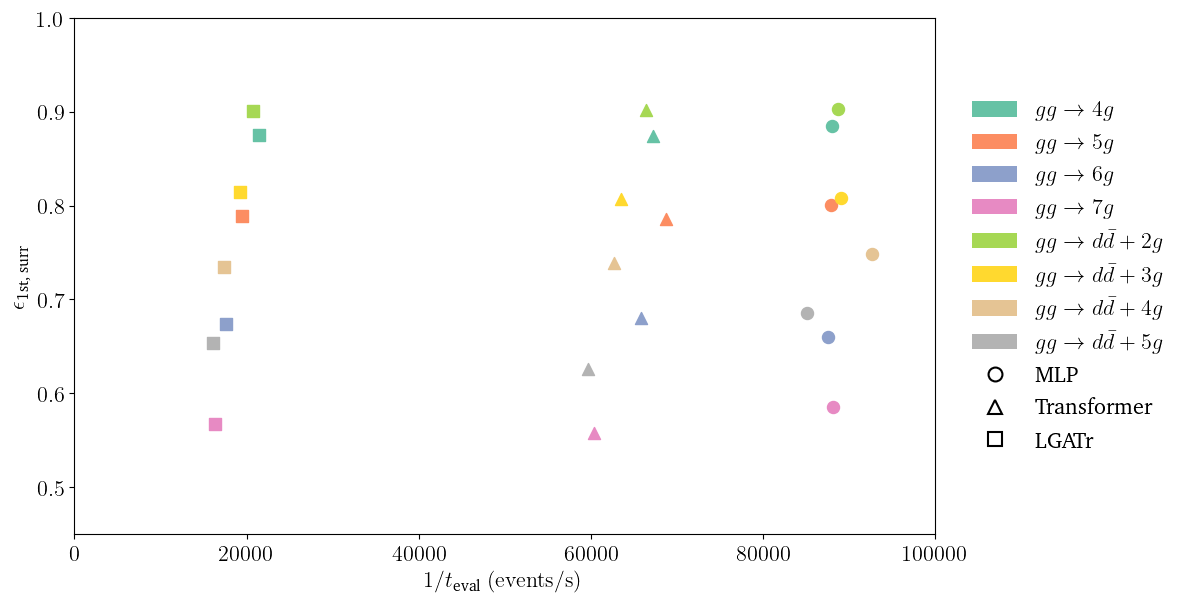

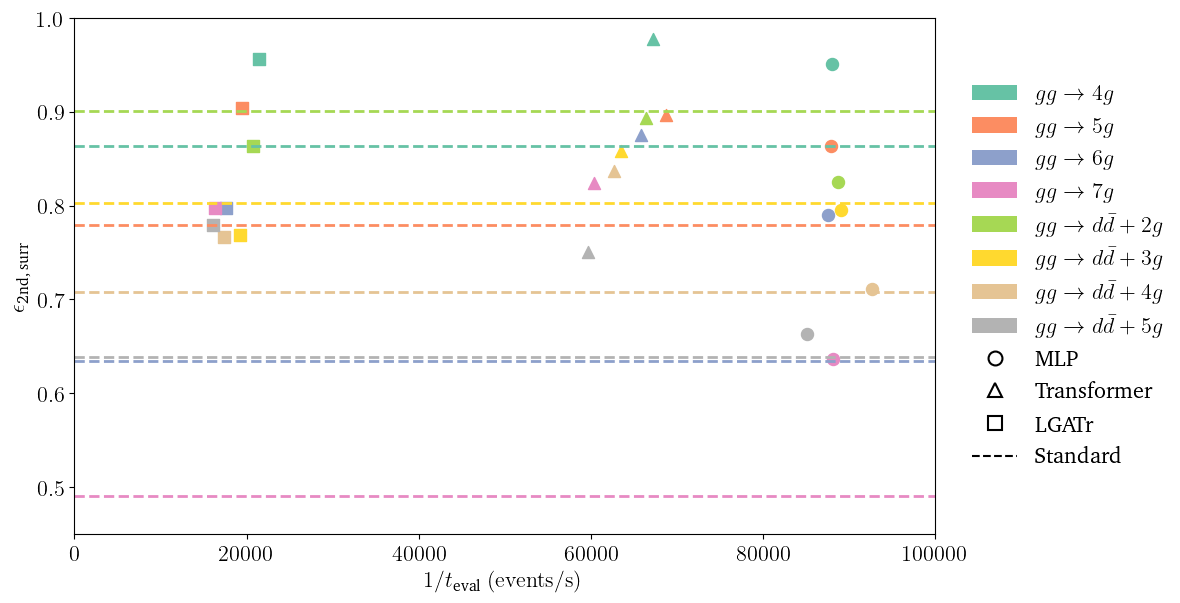

In [11]:
# Prepare colors and markers
datasets = list(eval_time.keys())
networks = list(next(iter(eval_time.values())).keys())

# Split datasets
gg_ng = sorted([ds for ds in datasets if "ddbar" not in ds])
gg_ddbar = sorted([ds for ds in datasets if "ddbar" in ds])

# Assign different colormaps
dataset_colors = {
    **{
        ds: cm.get_cmap("Set2", len(gg_ng) + len(gg_ddbar))(i)
        for i, ds in enumerate([*gg_ng, *gg_ddbar])
    }
}
network_markers = {"MLP": "o", "Transformer": "^", "LGATr": "s"}

with PdfPages("figs/new_dataset/regression/eff_vs_evalt.pdf") as pp:
    for i, eff in enumerate([unw_efficiency1, unw_efficiency2]):
        eff_label = [r"$\epsilon_{\text{1st, surr}}$", r"$\epsilon_{\text{2nd, surr}}$"][
            i
        ]
        fig, ax = plt.subplots(figsize=(2.0 * figsize[0], 1.3 * figsize[1]))
        fig.tight_layout(
            pad=0.0, w_pad=0.0, h_pad=0.0, rect=(0.05, 0.05, 0.81, 1)
        )  # left, bottom, right, top margins
        # ax.grid()
        if i == 1:
            for ds in datasets:
                ax.axhline(
                    eff[ds]["standard"],
                    color=dataset_colors[ds],
                    linestyle="--",
                    linewidth=2,
                    alpha=1,
                )
        for ds in datasets:
            for net in networks:
                x = 1 / (eval_time[ds][net] / 300_000)
                y = eff[ds][net]
                ax.scatter(
                    x,
                    y,
                    color=dataset_colors[ds],
                    marker=network_markers[net],
                    s=75,
                )
        dataset_handles = [
            Patch(facecolor=dataset_colors[ds], label=ds_names[ds])
            for ds in sorted(datasets)
        ]
        network_handles = [
            plt.Line2D(
                [0],
                [0],
                marker=network_markers[net],
                color="none",  # No fill
                markerfacecolor="none",  # Transparent fill
                markeredgecolor="black",  # Black border (or use dataset color if you want)
                linestyle="",
                label=net,
                markersize=10,
                markeredgewidth=1.5,
            )
            for net in networks
        ]
        if i == 1:
            standard_handle = plt.Line2D(
                [0], [0], color="black", linestyle="--", label="Standard"
            )
        else:
            standard_handle = None

        # Combine both types into a single legend
        combined_handles = (
            dataset_handles + network_handles + int(i == 1) * [standard_handle]
        )
        combined_labels = [h.get_label() for h in combined_handles]

        # Add legend outside
        ax.legend(
            handles=combined_handles,
            labels=combined_labels,
            loc="center left",
            bbox_to_anchor=(1.02, 0.5),
            frameon=False,
            ncol=1,
        )

        ax.set_xlabel(r"$1 / t_{\text{eval}}\ (\mathrm{events / s})$")
        ax.set_ylabel(eff_label)

        handles, labels = ax.get_legend_handles_labels()
        ax.set_ylim(0.45, 1.0)
        ax.set_xlim(0, 100_000)
        fig.savefig(pp, format="pdf")

## Grokking studies

### Losses plots

In [2]:
files = [
    "results/Transformer/Grokking/0724_095354-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_095354-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_095355-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_100335-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_101053-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_101227-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_101238-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_101258-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_110133-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_110817-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_120203-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_120206-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_120340-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_123618-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_124655-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_130211-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0724_134328-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_152444-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_152505-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_152524-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_161432-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_162201-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_164337-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_164820-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_165334-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_173928-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_174029-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_175321-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_175533-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_175738-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_181039-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_181206-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_181839-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_181908-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182145-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182246-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182459-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182502-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_182751-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_184727-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_185958-GrokkingExp-r-gg_4g-mse-emb_12-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_191353-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_191936-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_192440-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_192958-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_193238-GrokkingExp-r-gg_4g-mse-emb_72-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_193629-GrokkingExp-r-gg_4g-mse-emb_24-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_193915-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_194000-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0725_195438-GrokkingExp-r-gg_4g-mse-emb_96-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181250-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181308-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181333-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181358-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181422-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181447-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181512-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181537-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181611-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
    "results/Transformer/Grokking/0727_181629-GrokkingExp-r-gg_4g-mse-emb_18-3-bs_2k-false-pdrop_0p1-arctanh_F-lr_1e-3",
]

In [4]:
# I want to now recursively without the use of any function load the files in each directory of gg_4g_files and save results/MLP/0708_153354-HET-r-long/pkl/factors_tst.pkl

# Load pickle files from each directory and extract specific keys
results = {}
emb_12 = []
emb_18 = []
emb_24 = []
emb_48 = []
emb_72 = []
emb_96 = []
for file_path in files:
    path = os.path.join("../../", file_path)
    try:
        losses = load(os.path.join(path, "model"), "final")
        # the keys inside results should be either "AFC- or "r- (dependilosses on if FC or r is found on the namefile) and then -MSE" or -HET" dependilosses what is found on the namefile
        if "emb_12" in file_path:
            label = "emb_12"
            emb_12.append(losses)
        elif "emb_18" in file_path:
            label = "emb_18"
            emb_18.append(losses)
        elif "emb_24" in file_path:
            label = "24"
            emb_24.append(losses)
        elif "emb_48" in file_path:
            label = "48"
            emb_48.append(losses)
        elif "emb_72" in file_path:
            label = "72"
            emb_72.append(losses)
        elif "emb_96" in file_path:
            label = "96"
            emb_96.append(losses)
        else:
            raise ValueError(f"Unknown embedding size in file path: {file_path}")
    except Exception as e:
        print(f"Error loading {pickle_path}: {e}")

for key, l in zip(
    ["emb_12", "emb_18", "emb_24", "emb_48", "emb_72", "emb_96"],
    [emb_12, emb_18, emb_24, emb_48, emb_72, emb_96],
):
    results[key] = l
    print(key, len(l), "files loaded")

emb_12 10 files loaded
emb_18 10 files loaded
emb_24 10 files loaded
emb_48 10 files loaded
emb_72 10 files loaded
emb_96 10 files loaded


In [6]:
for k in results:
    for file_losses in results[k]:
        print(len(file_losses["val"]))

171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171
171


/tmp/ipykernel_1821546/2580113935.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")  # continuous


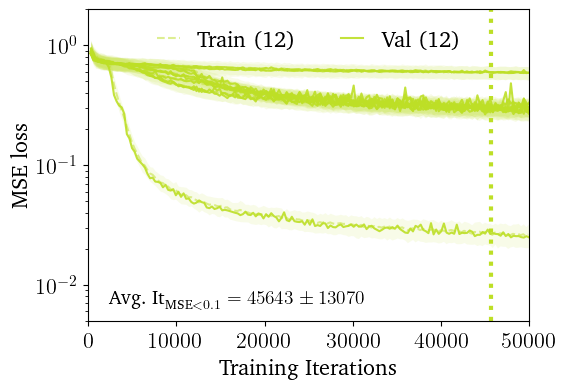

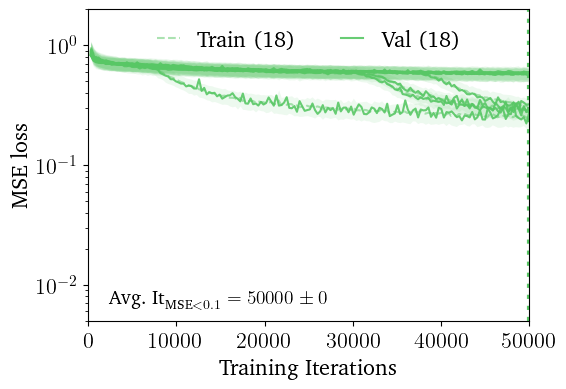

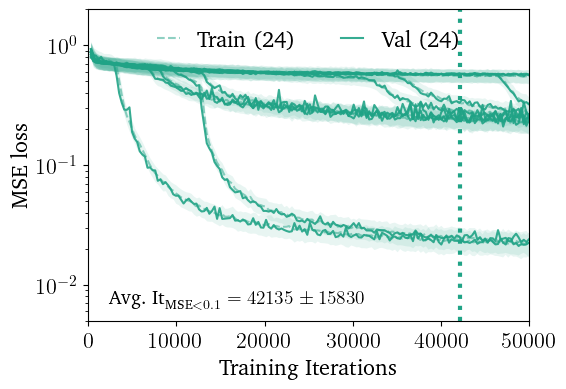

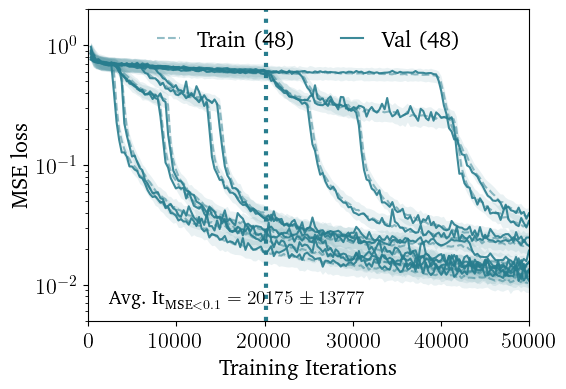

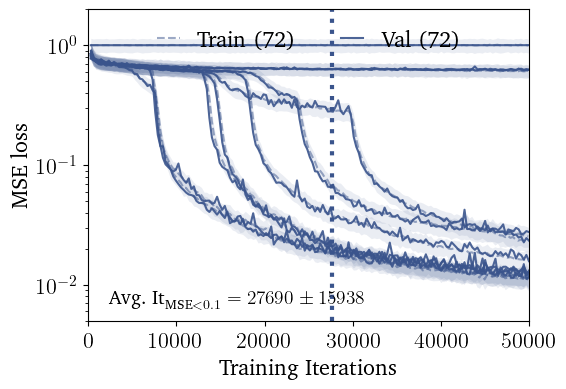

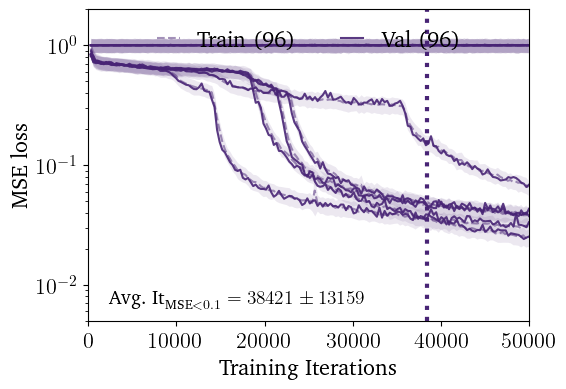

In [7]:
plt.rc("font", family="serif", size=16)
plt.rc("font", serif="Charter")
plt.rc("axes", titlesize="medium")
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
plt.rc("text", usetex=True)
dims = [12, 18, 24, 48, 72, 96]
import matplotlib.cm as cm

cmap = cm.get_cmap("viridis")  # continuous

lo, hi = 0.1, 0.9  # pick your range
n_models = len(results)
positions = np.linspace(lo, hi, n_models)
train_cols = [cmap(p) for p in reversed(positions)]
# train_cols = [f"C{i}"                     for i in range(n_models)]
# val_cols   = [f"C{i + 2 + 2*n_models}"    for i in range(n_models)]
val_cols = train_cols.copy()
with PdfPages("figs/new_dataset/grok-gg_4g-losses-all.pdf") as pp:
    for dim in dims:
        fig, ax = plt.subplots(figsize=figsize)
        fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=rect)

        for idx, (name, runs) in enumerate(results.items()):
            if name != f"emb_{dim}":
                continue
            train_c, val_c = train_cols[idx], val_cols[idx]
            emb_label = name.split("_")[1]

            max_len_val = len(runs[0]["val"])
            val_matrix = np.zeros((max_len_val, len(runs)))
            trn_matrix = np.zeros((len(runs[0]["trn"]), len(runs)))

            position_where_val_crosses_0p1 = np.zeros((len(runs)))
            for run_idx, run in enumerate(runs):
                trn = np.array(run["trn"])
                val = np.array(run["val"])

                N = len(trn)
                M = len(val)
                factor = N // M
                avg_trn = np.array(
                    [trn[i * factor : (i + 1) * factor].mean() for i in range(M)]
                )
                std_trn = np.array(
                    [trn[i * factor : (i + 1) * factor].std() for i in range(M)]
                )
                x_avg_trn = np.arange(1, M + 1) * factor  # same scale as val

                ax.plot(
                    x_avg_trn,
                    avg_trn,
                    color=train_c,
                    linestyle="dashed",
                    alpha=0.5,
                    label=f"Train ({emb_label})" if run_idx == 0 else "",
                )
                # Plot std fill
                ax.fill_between(
                    x_avg_trn,
                    avg_trn - std_trn,
                    avg_trn + std_trn,
                    color=train_c,
                    alpha=0.1,
                    linewidth=0,
                    rasterized=True,  # helps keep PDF small
                )

                # x_trn = np.arange(1, len(trn) + 1)
                # # ax.plot(
                # #     x_trn, trn,
                # #     color=train_c, linestyle="solid", alpha=0.2,
                # #     label=f"Train ({emb_label})" if run_idx == 0 else ""
                # # )

                scale = len(trn) / len(val)  # handles early‑stop curves
                x_val = np.arange(1, len(val) + 1) * scale
                ax.plot(
                    x_val,
                    val,
                    # marker="o", markersize=3, markeredgewidth=0.6,
                    color=val_c,
                    linestyle="solid",
                    alpha=0.9,
                    label=f"Val ({emb_label})" if run_idx == 0 else "",
                )

                # store for mean curve
                # val_matrix[:len(val), run_idx] = val
                trn_matrix[: len(trn), run_idx] = trn
                position_where_val_crosses_0p1[run_idx] = (
                    x_val[val < 0.1].min() if np.any(val < 0.1) else 50_000
                )
                # break
            # mean_val = np.mean(val_matrix, axis=1)
            # ax.plot(
            #     x_val, mean_val,
            #     color=val_c, linestyle="solid",
            #     label=f"Avg. Val. ({emb_label})"
            # )
            # mean_trn = np.mean(trn_matrix, axis=1)
            # ax.plot(
            #     x_trn, mean_trn,
            #     color=train_c, linestyle="solid",
            #     label=f"Avg. Trn. ({emb_label})",
            #     alpha=0.2,
            # )
            if not np.all(np.isnan(position_where_val_crosses_0p1)):
                # ax.axhline(
                #     0.1, color="black", linestyle="dashed", alpha=0.1,
                # )
                # for pos in position_where_val_crosses_0p1:
                #     if not np.isnan(pos):
                #         ax.axvline(
                #             pos, color=val_c, linestyle="dotted", alpha=0.5,
                #         )
                ax.axvline(
                    np.nanmean(position_where_val_crosses_0p1),
                    color=val_c,
                    linestyle="dotted",
                    alpha=1.0,
                    linewidth=3,
                )

                ax.text(
                    2275,
                    0.0075,
                    rf"$\text{{Avg. It}}_{{\text{{MSE}}<0.1}} = {np.nanmean(position_where_val_crosses_0p1):.0f}\pm {np.nanstd(position_where_val_crosses_0p1):.0f}$",
                    color="black",
                    fontsize=14,
                    ha="left",
                    va="center",
                    rotation=0,
                    alpha=1.0,
                )

                # ax.fill_between(
                #     [position_where_val_crosses_0p1.mean() - position_where_val_crosses_0p1.std(),
                #         position_where_val_crosses_0p1.mean() + position_where_val_crosses_0p1.std()],
                #     0, 100,
                #     color=val_c, alpha=0.1,
                # )

        # ------------------------------------------------------------------
        # y‑axis scale: purely log if all training losses > 0, otherwise symlog
        # (same criterion as original—last loop’s 'run' is still in scope)
        # ------------------------------------------------------------------
        ax.set_yscale("log" if np.all(np.array(run["trn"]) > 0) else "symlog")

        # ------------------------------------------------------------------
        ax.set_ylim(0.005, 2)
        ax.set_xlim(0, 50000)
        ax.set_xlabel("Training Iterations")
        ax.set_ylabel("MSE loss")
        ax.xaxis.get_major_formatter().set_useOffset(False)
        ax.xaxis.get_major_formatter().set_scientific(False)

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            handles, labels, frameon=False, loc="upper center", ncol=2, handlelength=1.0
        )
        fig.savefig(pp, format="pdf")

### Different iterations

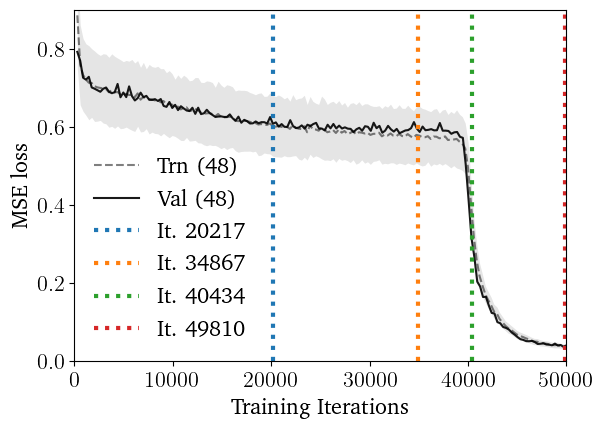

In [5]:
path = "../../results/Transformer/Grokking/0724_120206-GrokkingExp-r-gg_4g-mse-emb_48-bs_2k-pdrop_0p1-arctanh_F-lr_1e-3/model"
it_20217 = np.load(
    os.path.join(path, "preds_vs_targets_20217.npy"), allow_pickle=True
).item()
it_30179 = np.load(
    os.path.join(path, "preds_vs_targets_30179.npy"), allow_pickle=True
).item()
it_38383 = np.load(
    os.path.join(path, "preds_vs_targets_38383.npy"), allow_pickle=True
).item()
it_34867 = np.load(
    os.path.join(path, "preds_vs_targets_34867.npy"), allow_pickle=True
).item()
it_40434 = np.load(
    os.path.join(path, "preds_vs_targets_40434.npy"), allow_pickle=True
).item()
it_49810 = np.load(
    os.path.join(path, "preds_vs_targets_49810.npy"), allow_pickle=True
).item()
it_50000 = np.load(
    os.path.join(path, "preds_vs_targets_50000.npy"), allow_pickle=True
).item()
losses = load(path, "final")


iterations_checks = [20217, 34867, 40434, 49810]
colors = [f"C{i}" for i in range(len(iterations_checks))]
with PdfPages("figs/new_dataset/grok/its_comparison.pdf") as pp:
    fig, ax = plt.subplots(figsize=figsize)
    fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=rect)
    trn = np.array(losses["trn"])
    val = np.array(losses["val"])

    N = len(trn)
    M = len(val)
    factor = N // M
    avg_trn = np.array([trn[i * factor : (i + 1) * factor].mean() for i in range(M)])
    std_trn = np.array([trn[i * factor : (i + 1) * factor].std() for i in range(M)])
    x_avg_trn = np.arange(1, M + 1) * factor  # same scale as val

    ax.plot(
        x_avg_trn,
        avg_trn,
        color="black",
        linestyle="dashed",
        alpha=0.5,
        label=f"Trn (48)",
    )
    # Plot std fill
    ax.fill_between(
        x_avg_trn,
        avg_trn - std_trn,
        avg_trn + std_trn,
        color="black",
        alpha=0.1,
        linewidth=0,
        rasterized=True,  # helps keep PDF small
    )

    # x_trn = np.arange(1, len(trn) + 1)
    # # ax.plot(
    # #     x_trn, trn,
    # #     color=train_c, linestyle="solid", alpha=0.2,
    # #     label=f"Train ({emb_label})" if run_idx == 0 else ""
    # # )

    scale = len(trn) / len(val)  # handles early‑stop curves
    x_val = np.arange(1, len(val) + 1) * scale
    ax.plot(
        x_val,
        val,
        # marker="o", markersize=3, markeredgewidth=0.6,
        color="black",
        linestyle="solid",
        alpha=0.9,
        label=f"Val (48)",
    )
    for i, c in enumerate(colors):
        ax.axvline(
            iterations_checks[i],
            color=c,
            linestyle="dotted",
            alpha=1.0,
            linewidth=3,
            label=f"It. {iterations_checks[i]}",
        )
    ax.set_yscale("linear")
    ax.set_ylim(0.000, 0.9)
    ax.set_xlim(0, 50000)
    ax.set_xlabel("Training Iterations")
    ax.set_ylabel("MSE loss")
    ax.xaxis.get_major_formatter().set_useOffset(False)
    ax.xaxis.get_major_formatter().set_scientific(False)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, frameon=False, loc="lower left")
    fig.subplots_adjust(left=rect[0], bottom=rect[1], right=rect[2], top=rect[3])
    fig.savefig(pp, format="pdf")

    truth = it_20217["targets"]
    preds_20217 = it_20217["preds"]
    preds_30179 = it_30179["preds"]
    preds_34867 = it_34867["preds"]
    preds_40434 = it_40434["preds"]
    preds_49810 = it_49810["preds"]
    preds_50000 = it_50000["preds"]

    # undo standardization
    for (truths, preds) in zip(
        [
            truth,
            it_30179["targets"],
            it_34867["targets"],
            it_40434["targets"],
            it_49810["targets"],
            it_50000["targets"],
        ],
        [preds_20217, preds_30179, preds_34867, preds_40434, preds_49810, preds_50000],
    ):
        truths[:] = truths * (0.0097 + 1e-15) + 0.8925
        preds[:] = preds * (0.0097 + 1e-15) + 0.8925

    # plot the predictions
    bins = np.linspace(0.85, 1.05, 64)

    y_truth, y_err = compute_hist_data(bins, truth, bayesian=False)
    y_preds_20217, y_err_20217 = compute_hist_data(bins, preds_20217, bayesian=False)
    # y_preds_30179, y_err_30179 = compute_hist_data(
    # bins, preds_30179, bayesian=False
    # )
    y_preds_34867, y_err_34867 = compute_hist_data(bins, preds_34867, bayesian=False)
    y_preds_40434, y_err_40434 = compute_hist_data(bins, preds_40434, bayesian=False)
    y_preds_49810, y_err_49810 = compute_hist_data(bins, preds_49810, bayesian=False)
    # y_preds_50000, y_err_50000 = compute_hist_data(
    # bins, preds_50000, bayesian=False
    # )
    lines = [
        Line(
            y=y_truth,
            y_err=y_err,
            label="Truth",
            color=TRUTH_COLOR,
        )
    ]
    for c, (y_preds, y_err_preds, it) in enumerate(
        zip(
            [y_preds_20217, y_preds_34867, y_preds_40434, y_preds_49810],
            [y_err_20217, y_err_34867, y_err_40434, y_err_49810],
            iterations_checks,
        )
    ):
        lines.append(
            Line(
                y=y_preds,
                y_err=y_err_preds,
                y_ref=y_truth,
                label=f"Preds. It. {it}",
                color=colors[c],
                alpha=0.5,
            )
        )

    hist_weights_plot(
        pp,
        lines,
        bins,
        show_ratios=False,
        xlabel=r"$r(x)$",
        xscale="linear",
        title=r"$gg\to 4g$",
        no_scale=True,
        rect=rect,
    )

    # plot the truth/pred
    bins = np.linspace(0.9, 1.1, 64)

    y_ratios_20217, y_err_20217 = compute_hist_data(
        bins, it_20217["targets"] / preds_20217, bayesian=False
    )
    # y_ratios_30179, y_err_30179 = compute_hist_data(
    #     bins, it_30179["targets"] / preds_20217, bayesian=False
    # )
    y_ratios_34867, y_err_34867 = compute_hist_data(
        bins, it_34867["targets"] / preds_34867, bayesian=False
    )
    y_ratios_40434, y_err_40434 = compute_hist_data(
        bins, it_40434["targets"] / preds_40434, bayesian=False
    )
    y_ratios_49810, y_err_49810 = compute_hist_data(
        bins, it_49810["targets"] / preds_49810, bayesian=False
    )
    # y_ratios_50000, y_err_50000 = compute_hist_data(
    #     bins, it_50000["targets"] / preds_50000, bayesian=False
    # )
    lines = []
    for c, (y_ratios, y_err_ratios, it) in enumerate(
        zip(
            [y_ratios_20217, y_ratios_34867, y_ratios_40434, y_ratios_49810],
            [y_err_20217, y_err_34867, y_err_40434, y_err_49810],
            iterations_checks,
        )
    ):
        lines.append(
            Line(
                y=y_ratios,
                y_err=y_err_ratios,
                y_ref=None,
                label=f"It. {it}",
                color=colors[c],
                alpha=0.5,
            )
        )

    hist_weights_plot(
        pp,
        lines,
        bins,
        show_ratios=False,
        xlabel=r"$r^{\text{true}}/r^{\text{pred}}$",
        xscale="linear",
        title=r"$gg\to 4g$",
        no_scale=True,
        rect=rect,
    )

    # plot deltas
    bins = np.linspace(-0.1, 0.1, 64)

    y_deltas_20217, y_err_20217 = compute_hist_data(
        bins, (preds_20217 - it_20217["targets"]) / it_20217["targets"], bayesian=False
    )
    # y_deltas_30179, y_err_30179 = compute_hist_data(
    #     bins, (preds_30179 - it_30179["targets"]) / it_30179["targets"], bayesian=False
    # )
    y_deltas_34867, y_err_34867 = compute_hist_data(
        bins, (preds_34867 - it_34867["targets"]) / it_34867["targets"], bayesian=False
    )
    y_deltas_40434, y_err_40434 = compute_hist_data(
        bins, (preds_40434 - it_40434["targets"]) / it_40434["targets"], bayesian=False
    )
    y_deltas_49810, y_err_49810 = compute_hist_data(
        bins, (preds_49810 - it_49810["targets"]) / it_49810["targets"], bayesian=False
    )
    # y_deltas_50000, y_err_50000 = compute_hist_data(
    #     bins, (preds_50000 - it_50000["targets"]) / it_50000["targets"], bayesian=False
    # )
    lines = []
    for c, (y_deltas, y_err_deltas, it) in enumerate(
        zip(
            [y_deltas_20217, y_deltas_34867, y_deltas_40434, y_deltas_49810],
            [y_err_20217, y_err_34867, y_err_40434, y_err_49810],
            iterations_checks,
        )
    ):
        lines.append(
            Line(
                y=y_deltas,
                y_err=y_err_deltas,
                y_ref=None,
                label=f"It. {it}",
                color=colors[c],
                alpha=0.5,
            )
        )

    hist_weights_plot(
        pp,
        lines,
        bins,
        show_ratios=False,
        xlabel=r"$\Delta_{r} = \frac{r^{\text{pred}} - r^{\text{true}}}{r^{\text{true}}}$",
        xscale="linear",
        title=r"$gg\to 4g$",
        no_scale=True,
        rect=rect,
    )

    # plot abs deltas
    bins = np.logspace(-10, -0.5, 64)

    y_absdeltas_20217, y_err_20217 = compute_hist_data(
        bins,
        np.abs(preds_20217 - it_20217["targets"]) / it_20217["targets"],
        bayesian=False,
    )
    # y_absdeltas_30179, y_err_30179 = compute_hist_data(
    #     bins, np.abs(preds_30179 - it_30179["targets"]) / it_30179["targets"], bayesian=False
    # )
    y_absdeltas_34867, y_err_34867 = compute_hist_data(
        bins,
        np.abs(preds_34867 - it_34867["targets"]) / it_34867["targets"],
        bayesian=False,
    )
    y_absdeltas_40434, y_err_40434 = compute_hist_data(
        bins,
        np.abs(preds_40434 - it_40434["targets"]) / it_40434["targets"],
        bayesian=False,
    )
    y_absdeltas_49810, y_err_49810 = compute_hist_data(
        bins,
        np.abs(preds_49810 - it_49810["targets"]) / it_49810["targets"],
        bayesian=False,
    )
    # y_absdeltas_50000, y_err_50000 = compute_hist_data(
    #     bins, np.abs(preds_50000 - it_50000["targets"]) / it_50000["targets"], bayesian=False
    # )
    lines = []
    for c, (y_absdeltas, y_err_deltas, it) in enumerate(
        zip(
            [y_absdeltas_20217, y_absdeltas_34867, y_absdeltas_40434, y_absdeltas_49810],
            [y_err_20217, y_err_34867, y_err_40434, y_err_49810],
            iterations_checks,
        )
    ):
        lines.append(
            Line(
                y=y_absdeltas,
                y_err=y_err_deltas,
                y_ref=None,
                label=f"It. {it}",
                color=colors[c],
                alpha=0.5,
            )
        )

    hist_weights_plot(
        pp,
        lines,
        bins,
        show_ratios=False,
        xlabel=r"$|\Delta_{r}|$",
        xscale="log",
        title=r"$gg\to 4g$",
        no_scale=True,
        rect=rect,
        legend_kwargs={
            "loc": "center left",
        },
    )

### Test of symmetries

In [52]:
COLOR_BOOST = "firebrick"
COLOR_SO3 = "hotpink"
COLOR_SL4 = "#9370DB"
COLOR_SHEAR = "darkorange"
COLOR_SO2 = "#1E90FF"
# get all filenames in results/Transformer/Grokking-bigger_shear
SymmetriesTest_files = [
    "results/Transformer/Grokking-bigger_shear/" + fname
    for fname in os.listdir("../../results/Transformer/Grokking-bigger_shear")
]
# find the position of '0803_141013-GrokkingExp-SymmetriesTest-bigger_shear-19'
pos = [
    i
    for i, fname in enumerate(SymmetriesTest_files)
    if "0803_141013-GrokkingExp-SymmetriesTest-bigger_shear-19" in fname
]
print(pos)
print(f"Found {len(SymmetriesTest_files)} symmetry test files.")


def read_symmetry_file(filename):
    symmetry_types = ["SO2", "SO3", "boost", "SL4", "shear"]
    metrics = {
        "mu": "mu_deltas_{}_abs",
        "median": "median_deltas_{}_abs",
        "sigma": "std_deltas_{}_abs",
        "loss_median": "loss_{}_median",
        "loss_mean": "loss_{}_mean",
    }
    data = {}

    with open(filename, "r") as f:
        for line in f:
            if not line.strip():
                continue
            parts = line.strip().split(",")
            entry = {}
            iter_num = None
            for p in parts:
                key, val = p.strip().split(":", 1)
                key = key.strip()
                val = float(val.strip())
                if key == "iteration":
                    iter_num = int(val)
                    entry = {}
                else:
                    entry[key] = val

            # Structure the entry by symmetry and metrics
            out = {}
            for sym in symmetry_types:
                out[sym] = {
                    "mu": entry.get(f"mu_deltas_{sym}_abs"),
                    "median": entry.get(f"median_deltas_{sym}_abs"),
                    "sigma": entry.get(f"std_deltas_{sym}_abs"),
                    "loss_median": entry.get(f"loss_{sym}_median")
                    if sym != "boost"
                    else entry.get(f"loss_boosted_median"),
                    "loss_mean": entry.get(f"loss_{sym}_mean")
                    if sym != "boost"
                    else entry.get(f"loss_boosted_mean"),
                }
                out["mse_loss_median"] = entry.get("loss_median", None)
            data[iter_num] = out
    return data


def extract_mus(data):
    symmetry_types = ["SO2", "SO3", "boost", "SL4", "shear"]
    x = sorted(data.keys())
    mu = {sym: [data[it][sym]["mu"] for it in x] for sym in symmetry_types}
    median = {sym: [data[it][sym]["mu"] for it in x] for sym in symmetry_types}
    sigma = {sym: data[it][sym]["sigma"] for it in x for sym in symmetry_types}
    sym_loss_median = {
        sym: [data[it][sym]["loss_median"] for it in x] for sym in symmetry_types
    }
    sym_loss_mean = {
        sym: [data[it][sym]["loss_mean"] for it in x] for sym in symmetry_types
    }
    mse_loss_median = [
        data[it]["mse_loss_median"] for it in x if "mse_loss_median" in data[it]
    ]
    return x, mu, median, sigma, sym_loss_median, sym_loss_mean, mse_loss_median

[60]
Found 90 symmetry test files.


In [53]:
symmetry_types = ["SO2", "SO3", "boost", "SL4", "shear"]


x_ref = np.zeros((len(SymmetriesTest_files), 171))
mu_matrix = {sym: np.zeros((len(SymmetriesTest_files), 171)) for sym in symmetry_types}
median_matrix = {
    sym: np.zeros((len(SymmetriesTest_files), 171)) for sym in symmetry_types
}
sigma_matrix = {sym: np.zeros((len(SymmetriesTest_files), 171)) for sym in symmetry_types}
sym_loss_median_matrix = {
    sym: np.zeros((len(SymmetriesTest_files), 171)) for sym in symmetry_types
}
sym_loss_mean_matrix = {
    sym: np.zeros((len(SymmetriesTest_files), 171)) for sym in symmetry_types
}
mse_loss_median_matrix = np.zeros((len(SymmetriesTest_files), 171))

mse_loss_mean_matrix = np.zeros((len(SymmetriesTest_files), 171))

for i, f in enumerate(SymmetriesTest_files):
    logfile = os.path.join("../../", f, "grokking.log")
    result = read_symmetry_file(logfile)
    x, mu, median, sigma, sym_loss_median, sym_loss_mean, mse_loss_median = extract_mus(
        result
    )
    x_ref[i, :] = x  # store the x values for reference
    for sym in symmetry_types:
        mu_matrix[sym][i, :] = mu[sym]
        median_matrix[sym][i, :] = median[sym]
        sigma_matrix[sym][i, :] = sigma[sym]
        sym_loss_median_matrix[sym][i, :] = sym_loss_median[sym]
        sym_loss_mean_matrix[sym][i, :] = sym_loss_mean[sym]

        mse_loss_median_matrix[i, :] = mse_loss_median
    mse_loss_mean = load(os.path.join("../../", f, "model"), "final")["val"]
    mse_loss_mean_matrix[i, :] = mse_loss_mean  # store the losses for this file

In [67]:
def moving_average(arr, window=10):
    """Simple moving average with reflection at edges."""
    return np.convolve(arr, np.ones(window) / window, mode="same")


window = 1  # or any window size you prefer
corr_matrix = {sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types}
corr_trends_matrix = {
    sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types
}

mask = np.ones_like(x_ref[0], dtype=bool)
# mask = x_ref[0] > 10000


with PdfPages("figs/new_dataset/grok/delta_median-vs-MSE_median.pdf") as pp:
    for i in range(len(SymmetriesTest_files)):
        fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
        axright = ax.twinx()
        axright.set_yscale("log")
        axright.set_ylabel(r"Med(MSE loss)", color="forestgreen")
        axright.spines["right"].set_color("forestgreen")
        axright.yaxis.label.set_color("forestgreen")
        axright.tick_params(axis="y", colors="forestgreen")
        axright.yaxis.set_minor_locator(ticker.LogLocator(subs="auto", numticks=10))
        axright.tick_params(axis="y", which="minor", colors="forestgreen")
        axright.yaxis.set_minor_formatter(
            ticker.NullFormatter()
        )  # Hide minor tick labels if desired

        # masking
        x = x_ref[i][mask]
        mse_loss_mean = mse_loss_mean_matrix[i][mask]
        mse_loss_median = mse_loss_median_matrix[i][mask]
        median_SO2 = median_matrix["SO2"][i][mask]
        median_boost = median_matrix["boost"][i][mask]
        median_SO3 = median_matrix["SO3"][i][mask]
        median_SL4 = median_matrix["SL4"][i][mask]
        median_shear = median_matrix["shear"][i][mask]

        ma_mse_loss_mean = moving_average(mse_loss_mean, window)
        ma_mse_loss_median = moving_average(mse_loss_median, window)
        # axright.plot(x, ma_mse_loss_mean, label=f'Mean loss {i}', linestyle='dotted', color = 'forestgreen', linewidth=2, alpha = 0.75)
        axright.plot(
            x,
            ma_mse_loss_median,
            label=None,
            color="forestgreen",
            linewidth=2,
            alpha=0.75,
        )

        # SO(2)
        ma_median_SO2 = moving_average(median_SO2, window)
        ax.plot(
            x,
            ma_median_SO2,
            label=f"SO(2)",
            color=COLOR_SO2,
            linestyle="solid",
            linewidth=2,
            alpha=0.75,
        )

        # Boost
        ma_median_boost = moving_average(median_boost, window)
        ax.plot(
            x,
            ma_median_boost,
            label=f"Boost",
            color=COLOR_BOOST,
            linestyle="solid",
            linewidth=2,
            alpha=0.75,
        )

        # SO(3)
        ma_median_SO3 = moving_average(median_SO3, window)
        ax.plot(
            x,
            ma_median_SO3,
            label=f"SO(3)",
            color=COLOR_SO3,
            linestyle="solid",
            linewidth=2,
            alpha=0.75,
        )

        # SL(4)
        ma_median_SL4 = moving_average(median_SL4, window)
        ax.plot(
            x,
            ma_median_SL4,
            label=f"SL(4)",
            color=COLOR_SL4,
            linestyle="solid",
            linewidth=2,
            alpha=0.75,
        )

        # Shear
        ma_median_shear = moving_average(median_shear, window)
        ax.plot(
            x,
            ma_median_shear,
            label=f"Shear",
            color=COLOR_SHEAR,
            linestyle="solid",
            linewidth=2,
            alpha=0.75,
        )

        ax.set_xlabel("Training Iterations")
        ax.set_ylabel(r"$\text{Med}(\Delta_{\tilde{r}}^{g})$")
        ax.set_yscale("log")
        ax.set_ylim(0.005, 50)
        ax.set_xlim(0, 50000)
        handles1, labels1 = ax.get_legend_handles_labels()
        handles2, labels2 = axright.get_legend_handles_labels()

        # Combine
        handles = handles1 + handles2
        labels = labels1 + labels2
        ax.legend(handles, labels, frameon=False, loc="best", ncols=3, handlelength=1.0)
        fig.subplots_adjust(
            left=rect_both_axes[0],
            bottom=rect_both_axes[1],
            right=rect_both_axes[2],
            top=rect_both_axes[3],
        )
        fig.savefig(pp, format="pdf")
        plt.close()

        # fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
        # ax.scatter(
        #     mse_loss_median,
        #     median_SO2,
        #     label=f'SO(2)',
        #     color=COLOR_SO2,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_boost,
        #     label=f'Boost',
        #     color=COLOR_BOOST,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_SO3,
        #     label=f'SO(3)',
        #     color=COLOR_SO3,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_SL4,
        #     label=f'SL(4)',
        #     color=COLOR_SL4,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_shear,
        #     label=f'Shear',
        #     color=COLOR_SHEAR,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.set_xlabel(r"$\text{Med}(\text{MSE loss})$")
        # ax.set_ylabel(r"$\text{Med}(\Delta_{\tilde{r}}^{g})$")
        # ax.set_xscale('log')
        # ax.set_yscale('log')
        # ax.set_ylim(0.005, 50)
        # ax.legend(
        #     frameon=False,
        #     loc="best",
        #     ncols=3,
        #     handlelength=1.0,
        # )
        # fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
        # fig.savefig(pp, format="pdf")
        # plt.close()

        y = mse_loss_median

        corr = np.corrcoef(y, median_SO2)[0, 1]
        # print("Pearson correlation between SO(2) and Loss for file", i, ":", corr)
        corr_matrix["SO2"][i] = corr

        corr = np.corrcoef(y, median_boost)[0, 1]
        # print("Pearson correlation between Boost and Loss for file", i, ":", corr)
        corr_matrix["boost"][i] = corr

        corr = np.corrcoef(y, median_SO3)[0, 1]
        # print("Pearson correlation between SO(3) and Loss for file", i, ":", corr)
        corr_matrix["SO3"][i] = corr

        corr = np.corrcoef(y, median_SL4)[0, 1]
        # print("Pearson correlation between SL(4) and Loss for file", i, ":", corr)
        corr_matrix["SL4"][i] = corr

        corr = np.corrcoef(y, median_shear)[0, 1]
        # print("Pearson correlation between Shear and Loss for file", i, ":", corr)
        corr_matrix["shear"][i] = corr

    bins = np.linspace(-1.2, 1.2, 32)
    for sym, sym_label, sym_color in zip(
        ["SO2", "boost", "SO3", "SL4", "shear"],
        ["SO(2)", "Boost", "SO(3)", "SL(4)", "Shear"],
        [COLOR_SO2, COLOR_BOOST, COLOR_SO3, COLOR_SL4, COLOR_SHEAR],
    ):

        y, y_err = compute_hist_data(bins, corr_matrix[sym], bayesian=False)
        lines = [
            Line(
                y=y,
                y_err=None,
                label=sym_label,
                color=sym_color,
                alpha=1.0,
                linestyle="solid",
                linewidth=2,
            ),
            Line(
                y=np.mean(corr_matrix[sym]),
                y_err=np.std(corr_matrix[sym]),
                label=None,  # rf"$\overline{{R_{{\mathbf{{X}}, \mathbf{{Y}}}}}} = {np.mean(corr_matrix[sym]):.2f} \pm {np.std(corr_matrix[sym]):.2f}$",
                color=sym_color,
                vline=True,
                alpha=0.5,
                linestyle="dotted",
                linewidth=2,
            ),
        ]

        hist_weights_plot(
            pp,
            lines,
            bins,
            show_ratios=False,
            xlabel=r"$R_{\mathbf{X}, \mathbf{Y}}$",
            xscale="linear",
            # title=r"$gg\to 4g$",
            no_scale=True,
            rect=(rect[0], rect[1], 0.95, rect[3]),
            yscale="linear",
            ylabel=r"Runs",
        )

In [68]:
corr_matrix = {sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types}
corr_trends_matrix = {
    sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types
}

with PdfPages("figs/new_dataset/grok/sym_loss_median-vs-MSE_median.pdf") as pp:
    for i in range(len(SymmetriesTest_files)):
        fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))

        # masking
        x = x_ref[i][mask]
        mse_loss_mean = mse_loss_mean_matrix[i][mask]
        mse_loss_median = mse_loss_median_matrix[i][mask]
        median_SO2 = sym_loss_median_matrix["SO2"][i][mask]
        median_boost = sym_loss_median_matrix["boost"][i][mask]
        median_SO3 = sym_loss_median_matrix["SO3"][i][mask]
        median_SL4 = sym_loss_median_matrix["SL4"][i][mask]
        median_shear = sym_loss_median_matrix["shear"][i][mask]

        ma_mse_loss_mean = moving_average(mse_loss_mean, window)
        ma_mse_loss_median = moving_average(mse_loss_median, window)
        # axright.plot(x, ma_mse_loss_mean, label=f'Mean loss {i}', linestyle='dotted', color = 'forestgreen', linewidth=2, alpha = 0.75)
        ax.plot(
            x,
            ma_mse_loss_median,
            label="No tfm.",
            color="forestgreen",
            linewidth=2,
            alpha=0.75,
        )

        # SO(2)
        ma_median_SO2 = moving_average(median_SO2, window)
        ax.plot(
            x,
            ma_median_SO2,
            label=f"SO(2)",
            color=COLOR_SO2,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # Boost
        ma_median_boost = moving_average(median_boost, window)
        ax.plot(
            x,
            ma_median_boost,
            label=f"Boost",
            color=COLOR_BOOST,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # SO(3)
        ma_median_SO3 = moving_average(median_SO3, window)
        ax.plot(
            x,
            ma_median_SO3,
            label=f"SO(3)",
            color=COLOR_SO3,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # SL(4)
        ma_median_SL4 = moving_average(median_SL4, window)
        ax.plot(
            x,
            ma_median_SL4,
            label=f"SL(4)",
            color=COLOR_SL4,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # Shear
        ma_median_shear = moving_average(median_shear, window)
        ax.plot(
            x,
            ma_median_shear,
            label=f"Shear",
            color=COLOR_SHEAR,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        ax.set_xlabel("Training Iterations")
        ax.set_ylabel(r"$\text{Med}(\text{MSE}^{g})$")
        ax.set_yscale("log")
        ax.set_ylim(2e-5, 5)
        ax.set_xlim(0, 50000)

        # Combine
        ax.legend(frameon=False, loc="best", ncols=3, handlelength=1.0)
        fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
        fig.savefig(pp, format="pdf")
        plt.close()

        # fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
        # ax.scatter(
        #     mse_loss_median,
        #     median_SO2,
        #     label=f'SO(2)',
        #     color=COLOR_SO2,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_boost,
        #     label=f'Boost',
        #     color=COLOR_BOOST,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_SO3,
        #     label=f'SO(3)',
        #     color=COLOR_SO3,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_SL4,
        #     label=f'SL(4)',
        #     color=COLOR_SL4,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_median,
        #     median_shear,
        #     label=f'Shear',
        #     color=COLOR_SHEAR,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.set_xlabel(r"$\text{Med}(\text{MSE}^{0})$")
        # ax.set_ylabel(r"$\text{Med}(\text{MSE}^{g})$")
        # ax.set_xscale('log')
        # ax.set_yscale('log')
        # ax.set_ylim(2e-5, 5)
        # ax.legend(
        #     frameon=False,
        #     loc="best",
        #     ncols=3,
        #     handlelength=1.0,
        # )
        # fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
        # fig.savefig(pp, format="pdf")
        # plt.close()

        y = mse_loss_median

        corr = np.corrcoef(y, median_SO2)[0, 1]
        # print("Pearson correlation between SO(2) and Loss for file", i, ":", corr)
        corr_matrix["SO2"][i] = corr

        corr = np.corrcoef(y, median_boost)[0, 1]
        # print("Pearson correlation between Boost and Loss for file", i, ":", corr)
        corr_matrix["boost"][i] = corr

        corr = np.corrcoef(y, median_SO3)[0, 1]
        # print("Pearson correlation between SO(3) and Loss for file", i, ":", corr)
        corr_matrix["SO3"][i] = corr

        corr = np.corrcoef(y, median_SL4)[0, 1]
        # print("Pearson correlation between SL(4) and Loss for file", i, ":", corr)
        corr_matrix["SL4"][i] = corr

        corr = np.corrcoef(y, median_shear)[0, 1]
        # print("Pearson correlation between Shear and Loss for file", i, ":", corr)
        corr_matrix["shear"][i] = corr

    for sym, sym_label, sym_color in zip(
        ["SO2", "boost", "SO3", "SL4", "shear"],
        ["SO(2)", "Boost", "SO(3)", "SL(4)", "Shear"],
        [COLOR_SO2, COLOR_BOOST, COLOR_SO3, COLOR_SL4, COLOR_SHEAR],
    ):
        if sym == "SO2":
            bins = np.linspace(0.9999, 1.0, 32)
        else:
            bins = np.linspace(-1.2, 1.2, 32)

        y, y_err = compute_hist_data(bins, corr_matrix[sym], bayesian=False)
        lines = [
            Line(
                y=y,
                y_err=None,
                label=sym_label,
                color=sym_color,
                alpha=1.0,
                linestyle="solid",
                linewidth=2,
            ),
            Line(
                y=np.mean(corr_matrix[sym]),
                y_err=np.std(corr_matrix[sym]),
                label=None,  # rf"$\overline{{R_{{\mathbf{{X}}, \mathbf{{Y}}}}}} = {np.mean(corr_matrix[sym]):.2f} \pm {np.std(corr_matrix[sym]):.2f}$" if sym != 'SO2' else rf"$\overline{{R_{{\mathbf{{X}}, \mathbf{{Y}}}}}} = {np.mean(corr_matrix[sym]):.2e} \pm {np.std(corr_matrix[sym]):.2e}$",
                color=sym_color,
                vline=True,
                alpha=0.5,
                linestyle="dotted",
                linewidth=2,
            ),
        ]

        hist_weights_plot(
            pp,
            lines,
            bins,
            show_ratios=False,
            xlabel=r"$R_{\mathbf{X}, \mathbf{Y}}$",
            xscale="linear",
            # title=r"$gg\to 4g$",
            no_scale=True,
            rect=(rect[0], rect[1], 0.95, rect[3]),
            yscale="linear",
            ylabel=r"Runs",
        )

In [69]:
corr_matrix = {sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types}
corr_trends_matrix = {
    sym: np.zeros((len(SymmetriesTest_files))) for sym in symmetry_types
}


with PdfPages("figs/new_dataset/grok/sym_loss_mean-vs-MSE_mean.pdf") as pp:
    for i in range(len(SymmetriesTest_files)):
        fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))

        # masking
        x = x_ref[i][mask]
        mse_loss_mean = mse_loss_mean_matrix[i][mask]
        mse_loss_mean = mse_loss_mean_matrix[i][mask]
        mean_SO2 = sym_loss_mean_matrix["SO2"][i][mask]
        mean_boost = sym_loss_mean_matrix["boost"][i][mask]
        mean_SO3 = sym_loss_mean_matrix["SO3"][i][mask]
        mean_SL4 = sym_loss_mean_matrix["SL4"][i][mask]
        mean_shear = sym_loss_mean_matrix["shear"][i][mask]

        ma_mse_loss_mean = moving_average(mse_loss_mean, window)
        ma_mse_loss_mean = moving_average(mse_loss_mean, window)
        ax.plot(
            x,
            ma_mse_loss_mean,
            label="No tfm.",
            linestyle="dotted",
            color="forestgreen",
            linewidth=2,
            alpha=0.75,
        )
        # ax.plot(x, ma_mse_loss_mean, label='No tfm.', color = 'forestgreen', linewidth=2, alpha = 0.75)

        # SO(2)
        ma_mean_SO2 = moving_average(mean_SO2, window)
        ax.plot(
            x,
            ma_mean_SO2,
            label=f"SO(2)",
            color=COLOR_SO2,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # Boost
        ma_mean_boost = moving_average(mean_boost, window)
        ax.plot(
            x,
            ma_mean_boost,
            label=f"Boost",
            color=COLOR_BOOST,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # SO(3)
        ma_mean_SO3 = moving_average(mean_SO3, window)
        ax.plot(
            x,
            ma_mean_SO3,
            label=f"SO(3)",
            color=COLOR_SO3,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # SL(4)
        ma_mean_SL4 = moving_average(mean_SL4, window)
        ax.plot(
            x,
            ma_mean_SL4,
            label=f"SL(4)",
            color=COLOR_SL4,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        # Shear
        ma_mean_shear = moving_average(mean_shear, window)
        ax.plot(
            x,
            ma_mean_shear,
            label=f"Shear",
            color=COLOR_SHEAR,
            linestyle="dashed",
            linewidth=2,
            alpha=0.75,
        )

        ax.set_xlabel("Training Iterations")
        ax.set_ylabel(r"$\text{Mean}(\text{MSE}^{g})$")
        ax.set_yscale("log")
        ax.set_ylim(2e-5, 5)
        ax.set_xlim(0, 50000)

        # Combine
        ax.legend(frameon=False, loc="best", ncols=3, handlelength=1.0)
        fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
        fig.savefig(pp, format="pdf")
        plt.close()

        # fig, ax = plt.subplots(figsize=(figsize[0], figsize[1]))
        # ax.scatter(
        #     mse_loss_mean,
        #     mean_SO2,
        #     label=f'SO(2)',
        #     color=COLOR_SO2,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_mean,
        #     mean_boost,
        #     label=f'Boost',
        #     color=COLOR_BOOST,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_mean,
        #     mean_SO3,
        #     label=f'SO(3)',
        #     color=COLOR_SO3,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_mean,
        #     mean_SL4,
        #     label=f'SL(4)',
        #     color=COLOR_SL4,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.scatter(
        #     mse_loss_mean,
        #     mean_shear,
        #     label=f'Shear',
        #     color=COLOR_SHEAR,
        #     alpha=0.25,
        #     # s=100,
        #     edgecolors='none',
        # )
        # ax.set_xlabel(r"$\text{Mean}(\text{MSE}^{0})$")
        # ax.set_ylabel(r"$\text{Mean}(\text{MSE}^{g})$")
        # ax.set_xscale('log')
        # ax.set_yscale('log')
        # ax.set_ylim(2e-5, 5)
        # ax.legend(
        #     frameon=False,
        #     loc="best",
        #     ncols=3,
        #     handlelength=1.0,
        # )
        # fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
        # fig.savefig(pp, format="pdf")
        # plt.close()

        y = mse_loss_mean

        corr = np.corrcoef(y, mean_SO2)[0, 1]
        # print("Pearson correlation between SO(2) and Loss for file", i, ":", corr)
        corr_matrix["SO2"][i] = corr

        corr = np.corrcoef(y, mean_boost)[0, 1]
        # print("Pearson correlation between Boost and Loss for file", i, ":", corr)
        corr_matrix["boost"][i] = corr

        corr = np.corrcoef(y, mean_SO3)[0, 1]
        # print("Pearson correlation between SO(3) and Loss for file", i, ":", corr)
        corr_matrix["SO3"][i] = corr

        corr = np.corrcoef(y, mean_SL4)[0, 1]
        # print("Pearson correlation between SL(4) and Loss for file", i, ":", corr)
        corr_matrix["SL4"][i] = corr

        corr = np.corrcoef(y, mean_shear)[0, 1]
        # print("Pearson correlation between Shear and Loss for file", i, ":", corr)
        corr_matrix["shear"][i] = corr

    bins = np.linspace(-1.2, 1.2, 32)
    for sym, sym_label, sym_color in zip(
        ["SO2", "boost", "SO3", "SL4", "shear"],
        ["SO(2)", "Boost", "SO(3)", "SL(4)", "Shear"],
        [COLOR_SO2, COLOR_BOOST, COLOR_SO3, COLOR_SL4, COLOR_SHEAR],
    ):
        y, y_err = compute_hist_data(bins, corr_matrix[sym], bayesian=False)
        lines = [
            Line(
                y=y,
                y_err=None,
                label=sym_label,
                color=sym_color,
                alpha=1.0,
                linestyle="solid",
                linewidth=2,
            ),
            Line(
                y=np.mean(corr_matrix[sym]),
                y_err=np.std(corr_matrix[sym]),
                label=None,  # rf"$\overline{{R_{{\mathbf{{X}}, \mathbf{{Y}}}}}} = {np.mean(corr_matrix[sym]):.2f} \pm {np.std(corr_matrix[sym]):.2f}$",
                color=sym_color,
                vline=True,
                alpha=0.5,
                linestyle="dotted",
                linewidth=2,
            ),
        ]
        hist_weights_plot(
            pp,
            lines,
            bins,
            show_ratios=False,
            xlabel=r"$R_{\mathbf{X}, \mathbf{Y}}$",
            xscale="linear",
            # title=r"$gg\to 4g$",
            no_scale=True,
            rect=(rect[0], rect[1], 0.95, rect[3]),
            yscale="linear",
            ylabel=r"Runs",
        )

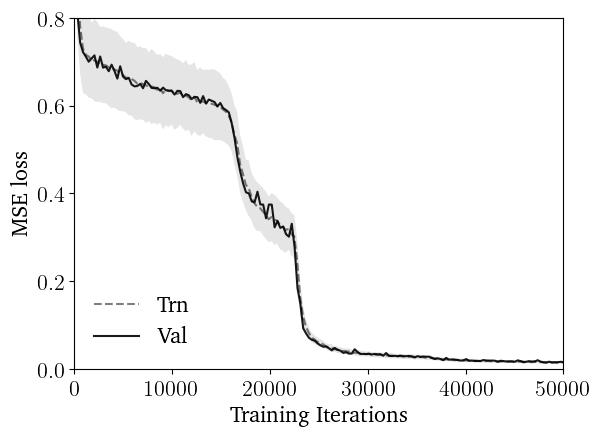

In [49]:
## Losses plot for overleaf :)
path = "../../results/Transformer/Grokking-bigger_shear/0803_141013-GrokkingExp-SymmetriesTest-bigger_shear-19/model"
losses = load(path, "final")
with PdfPages(
    "figs/new_dataset/grok/loss_plot-0803_141013-GrokkingExp-SymmetriesTest-bigger_shear-19.pdf"
) as pp:
    fig, ax = plt.subplots(figsize=figsize)
    fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0, rect=rect)
    trn = np.array(losses["trn"])
    val = np.array(losses["val"])

    N = len(trn)
    M = len(val)
    factor = N // M
    avg_trn = np.array([trn[i * factor : (i + 1) * factor].mean() for i in range(M)])
    std_trn = np.array([trn[i * factor : (i + 1) * factor].std() for i in range(M)])
    x_avg_trn = np.arange(1, M + 1) * factor  # same scale as val

    ax.plot(
        x_avg_trn,
        avg_trn,
        color="black",
        linestyle="dashed",
        alpha=0.5,
        label=f"Trn",
    )
    # Plot std fill
    ax.fill_between(
        x_avg_trn,
        avg_trn - std_trn,
        avg_trn + std_trn,
        color="black",
        alpha=0.1,
        linewidth=0,
        rasterized=True,  # helps keep PDF small
    )

    # x_trn = np.arange(1, len(trn) + 1)
    # # ax.plot(
    # #     x_trn, trn,
    # #     color=train_c, linestyle="solid", alpha=0.2,
    # #     label=f"Train ({emb_label})" if run_idx == 0 else ""
    # # )

    scale = len(trn) / len(val)  # handles early‑stop curves
    x_val = np.arange(1, len(val) + 1) * scale
    ax.plot(
        x_val,
        val,
        # marker="o", markersize=3, markeredgewidth=0.6,
        color="black",
        linestyle="solid",
        alpha=0.9,
        label=f"Val",
    )

    ax.set_yscale("linear")
    ax.set_ylim(0, 0.8)
    ax.set_xlim(0, 50000)
    ax.set_xlabel("Training Iterations")
    ax.set_ylabel("MSE loss")
    # ax.xaxis.get_major_formatter().set_useOffset(False)
    # ax.xaxis.get_major_formatter().set_scientific(False)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, frameon=False, loc="lower left")
    fig.subplots_adjust(left=rect[0], bottom=rect[1], right=0.95, top=rect[3])
    fig.savefig(pp, format="pdf")

In [60]:
# for k in range(len(SymmetriesTest_files)):
upper_bound = 0.1
lower_bound = 0.1
region1_mask = losses_matrix[:] > upper_bound
region2_mask = losses_matrix[:] < lower_bound

# median_below_10_mask = median_matrix['boost'][:] < 10
above_5000_its = x_ref[:] > 0
region1_mask = region1_mask & above_5000_its  # & median_below_10_mask
region2_mask = region2_mask & above_5000_its  # & median_below_10_mask

# Weights?
# weights1 = 1/losses_matrix[:][region1_mask] / np.sum(1/losses_matrix[:][region1_mask]) * region1_mask.sum()
# weights2 = 1/losses_matrix[:][region2_mask] / np.sum(1/losses_matrix[:][region2_mask]) * region2_mask.sum()
weights1 = np.ones_like(losses_matrix[:][region1_mask])
weights2 = np.ones_like(losses_matrix[:][region2_mask])

COLOR_SO2_2 = "forestgreen"
COLOR_SO3_2 = "orchid"
COLOR_BOOST_2 = "lightcoral"
COLOR_SL4_2 = "plum"
COLOR_SHEAR_2 = "wheat"

c = ["red"] * 5
COLOR_SO2, COLOR_SO3, COLOR_BOOST, COLOR_SL4, COLOR_SHEAR = c

c2 = ["blue"] * 5
COLOR_SO2_2, COLOR_SO3_2, COLOR_BOOST_2, COLOR_SL4_2, COLOR_SHEAR_2 = c2

with PdfPages("figs/new_dataset/grok/symmetries_test.pdf") as pp:
    bins = np.linspace(-10, 53, 64)

    # SO(2)
    y_median_SO21, y_err_median_SO21 = compute_hist_data(
        bins, median_matrix["SO2"][:][region1_mask], bayesian=False, weights=weights1
    )
    y_median_SO22, y_err_median_SO22 = compute_hist_data(
        bins, median_matrix["SO2"][:][region2_mask], bayesian=False, weights=weights2
    )
    lines = [
        Line(
            y=y_median_SO21,
            y_err=None,
            label=f"SO(2) MSE $>$ {upper_bound}",
            color=COLOR_SO2_2,
            linestyle="solid",
        ),
        Line(
            y=y_median_SO22,
            y_err=None,
            label=f"SO(2) MSE $<$ {lower_bound}",
            color=COLOR_SO2,
            linestyle="dashed",
        ),
    ]
    hist_weights_plot(
        pp,
        lines,
        bins,
        show_ratios=False,
        xlabel=r"$\text{Med}\ (|\Delta^{g}_{\tilde{r}}|)$",
        ylabel="Iterations",
        xscale="linear",
        yscale="log",
        title=r"$gg\to 4g$",
        no_scale=True,
        rect=rect,
        legend_kwargs={
            "loc": "best",
        },
    )

    # SO(3)
    y_median_SO31, y_err_median_SO31 = compute_hist_data(
        bins, median_matrix["SO3"][:][region1_mask], bayesian=False, weights=weights1
    )
    y_median_SO32, y_err_median_SO32 = compute_hist_data(
        bins, median_matrix["SO3"][:][region2_mask], bayesian=False, weights=weights2
    )
    lines = [
        Line(
            y=y_median_SO31,
            y_err=None,
            label=f"SO(3) MSE $>$ {upper_bound}",
            color=COLOR_SO3_2,
            linestyle="solid",
        ),
        Line(
            y=y_median_SO32,
            y_err=None,
            label=f"SO(3) MSE $<$ {lower_bound}",
            color=COLOR_SO3,
            linestyle="dashed",
        ),
    ]
    hist_weights_plot(
        pp,
        lines,
        bins,
        show_ratios=False,
        xlabel=r"$\text{Med}\ (|\Delta^{g}_{\tilde{r}}|)$",
        ylabel="Iterations",
        xscale="linear",
        yscale="log",
        title=r"$gg\to 4g$",
        no_scale=True,
        rect=rect,
        legend_kwargs={
            "loc": "best",
        },
    )

    # Boost
    y_median_boost1, y_err_median_boost1 = compute_hist_data(
        bins, median_matrix["boost"][:][region1_mask], bayesian=False, weights=weights1
    )
    y_median_boost2, y_err_median_boost2 = compute_hist_data(
        bins, median_matrix["boost"][:][region2_mask], bayesian=False, weights=weights2
    )
    lines = [
        Line(
            y=y_median_boost1,
            y_err=None,
            label=f"Boost MSE $>$ {upper_bound}",
            color=COLOR_BOOST_2,
            linestyle="solid",
        ),
        Line(
            y=y_median_boost2,
            y_err=None,
            label=f"Boost MSE $<$ {lower_bound}",
            color=COLOR_BOOST,
            linestyle="dashed",
        ),
    ]
    hist_weights_plot(
        pp,
        lines,
        bins,
        show_ratios=False,
        xlabel=r"$\text{Med}\ (|\Delta^{g}_{\tilde{r}}|)$",
        ylabel="Iterations",
        xscale="linear",
        yscale="log",
        title=r"$gg\to 4g$",
        no_scale=True,
        rect=rect,
        legend_kwargs={
            "loc": "best",
        },
    )

    # SL(4)
    y_median_SL41, y_err_median_SL41 = compute_hist_data(
        bins, median_matrix["SL4"][:][region1_mask], bayesian=False, weights=weights1
    )
    y_median_SL42, y_err_median_SL42 = compute_hist_data(
        bins, median_matrix["SL4"][:][region2_mask], bayesian=False, weights=weights2
    )
    lines = [
        Line(
            y=y_median_SL41,
            y_err=None,
            label=f"SL(4) MSE $>$ {upper_bound}",
            color=COLOR_SL4_2,
            linestyle="solid",
        ),
        Line(
            y=y_median_SL42,
            y_err=None,
            label=f"SL(4) MSE $<$ {lower_bound}",
            color=COLOR_SL4,
            linestyle="dashed",
        ),
    ]
    hist_weights_plot(
        pp,
        lines,
        bins,
        show_ratios=False,
        xlabel=r"$\text{Med}\ (|\Delta^{g}_{\tilde{r}}|)$",
        ylabel="Iterations",
        xscale="linear",
        yscale="log",
        title=r"$gg\to 4g$",
        no_scale=True,
        rect=rect,
        legend_kwargs={
            "loc": "best",
        },
    )

    # Shear
    y_median_shear1, y_err_median_shear1 = compute_hist_data(
        bins, median_matrix["shear"][:][region1_mask], bayesian=False, weights=weights1
    )
    y_median_shear2, y_err_median_shear2 = compute_hist_data(
        bins, median_matrix["shear"][:][region2_mask], bayesian=False, weights=weights2
    )
    lines = [
        Line(
            y=y_median_shear1,
            y_err=None,
            label=f"Shear MSE $>$ {upper_bound}",
            color=COLOR_SHEAR_2,
            linestyle="solid",
        ),
        Line(
            y=y_median_shear2,
            y_err=None,
            label=f"Shear MSE $<$ {lower_bound}",
            color=COLOR_SHEAR,
            linestyle="dashed",
        ),
    ]
    hist_weights_plot(
        pp,
        lines,
        bins,
        show_ratios=False,
        xlabel=r"$\text{Med}\ (|\Delta^{g}_{\tilde{r}}|)$",
        ylabel="Iterations",
        xscale="linear",
        yscale="log",
        title=r"$gg\to 4g$",
        no_scale=True,
        rect=rect,
        legend_kwargs={
            "loc": "best",
        },
    )

In [ ]:
# import scipy.optimize as so
# def linear(x, a, b):
#     return a + b * x
# def calc_r2(func, coef, x_true, y_true):
#     y_pred = func(x_true, *coef)
#     ss_res = np.sum((y_true - y_pred) ** 2)
#     ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
#     return 1 - ss_res / ss_tot


# fig, ax = plt.subplots(figsize=(10, 6))
# ax.scatter(losses_matrix[:][region1_mask], median_matrix['boost'][:][region1_mask], label=f'Boost MSE $>$ {upper_bound}', color=COLOR_BOOST, alpha=0.1)
# ax.scatter(losses_matrix[:][region2_mask], median_matrix['boost'][:][region2_mask], label=f'Boost MSE $<$ {lower_bound}', color="orangered", alpha=0.1)

# ax.scatter(losses_matrix[:][region1_mask], median_matrix['SO2'][:][region1_mask], label=f'Boost MSE $>$ {upper_bound}', color=COLOR_BOOST, alpha=0.1)
# ax.scatter(losses_matrix[:][region2_mask], median_matrix['SO2'][:][region2_mask], label=f'Boost MSE $<$ {lower_bound}', color="orangered", alpha=0.1)

# for i, (x,y, uy) in enumerate(zip(
#     [losses_matrix[:][region1_mask], losses_matrix[:][region2_mask]],
#     [median_matrix['boost'][:][region1_mask], median_matrix['boost'][:][region2_mask]],
#     [sigma_matrix['boost'][:][region1_mask], sigma_matrix['boost'][:][region2_mask]]
# )):
#     p0 = [0., 0.]
#     sol = so.curve_fit(linear, x, y, p0 = p0, sigma = uy, absolute_sigma = True)
#     coef, cov = sol; a, b = coef; xaux = np.linspace(min(x), max(x), 2); yaux = linear(xaux, *coef);
#     ua, ub = np.sqrt(np.diag(cov))
#     r2 = calc_r2(linear, coef, x, y)
#     ax.plot(xaux, yaux, color=COLOR_BOOST if i == 0 else "forestgreen", linestyle='dashed', label=f'R²={r2:.2f}')


#     # plt.legend(frameon=False, loc='best')
#     # plt.xlabel("MSE loss")
#     # plt.ylabel(r"$\text{Med}\ (|\Delta^{g}_{\tilde{r}}|)$")
#     # plt.tight_layout()
#     # plt.show()

In [5]:
data_dir = (
    "../../data/gg_ng/large/"
    if os.path.exists("../../data/gg_ng/large/")
    else "/remote/gpu02/marino/data/gg_ng/large/"
)
datasets_names = ["gg_4g", "gg_5g", "gg_6g", "gg_7g"]
# read data and pass to tensors
datasets = {
    datasets_names[0]: np.load(
        os.path.join(data_dir, "events_6_2_21_21_21_21_21_21_1_2_3_4_5_6.lhe.rwgt.npy")
    ),
    datasets_names[1]: np.load(
        os.path.join(
            data_dir, "events_7_2_21_21_21_21_21_21_21_1_2_3_4_5_6_7.lhe.rwgt.npy"
        )
    ),
    datasets_names[2]: np.load(
        os.path.join(
            data_dir, "events_8_2_21_21_21_21_21_21_21_21_1_2_3_4_5_6_7_8.lhe.rwgt.npy"
        )
    ),
    datasets_names[3]: np.load(
        os.path.join(
            data_dir,
            "events_9_2_21_21_21_21_21_21_21_21_21_1_2_3_4_5_6_7_8_9.lhe.rwgt.npy",
        )
    ),
}

In [156]:
# Load samples from
datasets = ["gg_4g", "gg_5g", "gg_6g", "gg_7g"]
events = defaultdict(lambda: defaultdict(dict))
samples = defaultdict(lambda: defaultdict(dict))
models = ["Transformer", "MLP", "LGATr", "LGATr-3M"]
for model in models:
    for dataset in datasets:
        for split in ["tst"]:
            path = glob.glob(
                f"files/benchmarks/Transformer/*-benchmark-{dataset}/samples/events_{split}.pt"
            )[0]
            events[dataset][split] = (
                torch.load(path, map_location="cpu").squeeze().numpy()
            )
            if model == "Transformer":
                samples[dataset][model][split] = (
                    torch.load(
                        glob.glob(
                            f"files/benchmarks/{model}/*-benchmark-{dataset}*one_hot/samples/predicted_factors_{split}.pt"
                        )[0],
                        map_location="cpu",
                    )
                    .squeeze()
                    .numpy()
                )
            else:
                samples[dataset][model][split] = (
                    torch.load(
                        glob.glob(
                            f"files/benchmarks/{model}/*-benchmark-{dataset}*/samples/predicted_factors_{split}.pt"
                        )[0],
                        map_location="cpu",
                    )
                    .squeeze()
                    .numpy()
                )

In [105]:
for process_name in datasets:
    plot_weights(
        events[process_name],
        samples[process_name],
        process_name=f"${process_name[:2]}\\to {process_name[-2:]}$",
        file=f"figs/benchmarks/{process_name}-weights.pdf",
        split="tst",
    )
    for model in models:
        plot_ratio_correlation(
            events[process_name],
            samples[process_name][model],
            process_name=f"${process_name[:2]}\\to {process_name[-2:]}$",
            file=f"figs/benchmarks/{process_name}-{model}-ratio_corr.pdf",
            model_name=model,
            split="tst",
        )